In [1]:
from plotter import plot_NEES, plot_NIS, plot_angle, plot_error_pos_sigma, plot_error_vel_sigma, plot_path, state_error_plots
from typing import Tuple, Sequence, Any
from matplotlib import pyplot as plt


# from plotfunctionstesting import plot_acc, plot_acc2, plot_gyro, plot_angle

import numpy as np
import scipy.linalg as la
import scipy
import scipy.io
import scipy.stats
from dataclasses import dataclass, field
import timeit
import time

import tqdm
import os
import sys

from tqdm import trange
from tqdm import tqdm_notebook

from quaternion import * 
from cat_slice import CatSlice
# from eskf import ESKF
# from eskf import ESKF

from utils import UDU_factorization

from eskf_batch import ESKF_batch
from eskf_sequential import ESKF_sequential
from eskf_UDU import ESKF_udu
from eskf_runner import run_batch_eskf, run_sequential_eskf, run_UDU_eskf
from plotter import * #plot_error_v_sigma, plot_pos, plot_vel, plot_angle, plot_estimate, plot_3Dpath, plot_path, state_error_plots, plot_NEES, plot_NIS
# from timer import * 

In [2]:
plt.close('all')

from plot_setup import setup_plot
setup_plot()
np.seterr(all='raise')
scipy.special.seterr(all='raise')

matplotlib backend: module://matplotlib_inline.backend_inline
matplotlib config file: C:\Python39\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\Users\Andreas\.matplotlib
Plotting is set to inline at the moment: unknown inline backend
continuing with this plotting backend


pyplot using style set ['science', 'grid', 'no-latex']


{'singular': 'ignore',
 'underflow': 'ignore',
 'overflow': 'ignore',
 'slow': 'ignore',
 'loss': 'ignore',
 'no_result': 'ignore',
 'domain': 'ignore',
 'arg': 'ignore',
 'other': 'ignore'}

In [3]:
"""
Q_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std
R: p_std -> R_GNSS = p_std**2*eye(3)
"""

'\nQ_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std\nR: p_std -> R_GNSS = p_std**2*eye(3)\n'

In [4]:
"""
Loads true state, time steps and other simulation variables. Run gen_mat to generate
new data
"""

folder = os.path.dirname(__file__)
# filename_to_load = f"{folder}/../data/simulation_params.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver2.mat"
filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver3.mat"
cache_folder = os.path.join(folder,'..', 'cache')
loaded_data = scipy.io.loadmat(filename_to_load)

timeIMU = loaded_data["timeIMU"].ravel()
#acc_t = loaded_data["acc_t"].T
if 'x_true' in loaded_data:
    x_true = loaded_data["x_true"].T
else:
    x_true = None
# z_GNSS = loaded_data["z_GNSS"].T
    
beacon_location = loaded_data["beacon_location"]

tGNSS = loaded_data["timeGNSS"].T
z_GNSS = loaded_data["z_GNSS"].T

z_acc_vector = loaded_data["z_acc"].T
acc_t = loaded_data["acc_t"].T
omega_t = loaded_data["omega_t"].T
z_gyro_vector = loaded_data["z_gyro"].T

dt = np.mean(np.diff(timeIMU))

In [5]:
POS_IDX = CatSlice(start=0, stop=3)
VEL_IDX = CatSlice(start=3, stop=6)
ATT_IDX = CatSlice(start=6, stop=10)
ACC_BIAS_IDX = CatSlice(start=10, stop=13)
GYRO_BIAS_IDX = CatSlice(start=13, stop=16)

ERR_ATT_IDX = CatSlice(start=6, stop=9)
ERR_ACC_BIAS_IDX = CatSlice(start=9, stop=12)
ERR_GYRO_BIAS_IDX = CatSlice(start=12, stop=15)

In [6]:
# Initializing prediction
x_pred_init = np.zeros(16)

# 8 figure init
x_pred_init[POS_IDX] = np.array([10,0,1])
x_pred_init[VEL_IDX] = np.array([0, 2, 0])
x_pred_init[6:10] = np.array([1,0,0,0]) #(0,0,0) iny euler
# x_pred_init[10:13] = np.array([-8.75e-2,-8.74e-2,6.9e-2])
# x_pred_init[13:16] = np.array([-9.54e-4,-7.32e-04,3.37e-04])

# x_pred_init[POS_IDX] = np.array([0, 0, -5])  # starting 5 metres above ground
# x_pred_init[VEL_IDX] = np.array([20, 0, 0])  # starting at 20 m/s due north
# no initial rotation: nose to North, right to East, and belly down
# x_pred_init[6] = 1

In [7]:
# acc_std = 7.59562072e-02
# rate_std =  5.12679127e-02

# cont_acc_bias_driving_noise_std =  1.16562328e-04
# cont_rate_bias_driving_noise_std =  1.94631260e-05

In [8]:
# TUNABLE0.01035
# cont_gyro_noise_std =  0.01035
cont_gyro_noise_std =   4.36e-5  # (rad/s)/sqrt(Hz)
# TUNABLE 0.015191 
# cont_acc_noise_std = np.array([0.01, 0.01, 0.042191])
# cont_acc_noise_std = 0.01549 #1.167e-2  # (m/s**2)/sqrt(Hz)
cont_acc_noise_std =  1.167e-2  # (m/s**2)/sqrt(Hz)

# cont_gyro_noise_std = 0.001      #4.36e-5  # (rad/s)/sqrt(Hz)
# cont_acc_noise_std = 0.001  #1.167e-3  # (m/s**2)/sqrt(Hz)

# Discrete sample noise at simulation rate used
# This is the formula from example 4.9. Should this be the driving noise instead?
rate_std = np.round(0.5 * cont_gyro_noise_std * np.sqrt(1 / dt),7) #Just to avoid float shit
acc_std = np.round(0.5 * cont_acc_noise_std * np.sqrt(1 / dt),7)

# Bias values
# TUNABLE 0.0005839  0.00005839 
# 5e-5 From another simulation
rate_bias_driving_noise_std =  5e-5 

cont_rate_bias_driving_noise_std = (
    np.round((1 / 3) * rate_bias_driving_noise_std / np.sqrt(1 / dt), 7)
)
#4e-3 From another simulation
#0.0001947, 0.0020947 0.0050947
acc_bias_driving_noise_std = 4e-3
cont_acc_bias_driving_noise_std = 6 * acc_bias_driving_noise_std / np.sqrt(1 / dt)

In [9]:
p_acc =   1.000e-6
p_gyro = 1.00000000e-6

In [10]:
# p_std = np.array([1.58170828, 1.58170828, 0.97243219])   # Measurement noise

#The measurements from the GNSS are perfect at the moment
# p_std = np.array([0, 0, 0])
p_std = np.array([.01, .01, .03])
# p_std = np.array([.1, .1, .3])
# p_std = np.array([.3, .3, .5])

In [11]:
P_pred_init = np.zeros((15,15))
P_pred_init[POS_IDX ** 2] = np.eye(3) * 3**2  
P_pred_init[VEL_IDX ** 2] = np.eye(3) * 2**2  #0.2
P_pred_init[ERR_ATT_IDX ** 2] = np.eye(3) * 0.5**2  # TODO
P_pred_init[ERR_ACC_BIAS_IDX ** 2] = np.eye(3) * 0.01**2 
P_pred_init[ERR_GYRO_BIAS_IDX ** 2] = np.eye(3) * 0.001**2 # 0.001**2 
 
eskf_parameters = [acc_std,
                    rate_std,
                    cont_acc_bias_driving_noise_std,
                    cont_rate_bias_driving_noise_std,
                    p_acc,
                    p_gyro]   

In [12]:
#Number of seconds of simulation to run. len(timeIMU) decides max
# N: int = int(1000/dt)
N: int = int(10/dt) 
# N: int = int(600/dt) 
# N: int = int(90000)
# N: int = len(timeIMU)
offset = 0
doGNSS: bool = True
# rtol = 1e-05
# atol = 1e-08

In [13]:
# plt.close("all")
t = np.linspace(0,dt * (N-1), N)
# plot_path(t, N, pos_t, pos_t)

In [14]:
"""
Running the simulation
"""
beacon_location: np.ndarray = loaded_data["beacon_location"]

use_batch_pseudoranges: bool = True
# use_batch_pseudoranges: bool = False
use_sequential_pseudoranges: bool = True
# use_sequential_pseudoranges: bool = False
use_UDU: bool = True
# use_UDU: bool = False

num_beacons = len(beacon_location)
num_sims = 5

#Timers for batch-filter
t_batch = np.zeros(num_sims)
elapsed_batch = np.zeros(num_sims)

#Timers for sequential filter
t_sequential = np.zeros(num_sims)
elapsed_sequential = np.zeros(num_sims)

#Timers for UDU filter
t_UDU = np.zeros(num_sims)
elapsed_UDU = np.zeros(num_sims)

#Timers for submodules
total_elapsed_pred_timer_batch = np.zeros(num_sims)
total_elapsed_est_timer_batch = np.zeros(num_sims)
average_elapsed_pred_timer_batch = np.zeros(num_sims)
average_elapsed_est_timer_batch = np.zeros(num_sims)

total_elapsed_pred_timer_sequential = np.zeros(num_sims)
total_elapsed_est_timer_sequential = np.zeros(num_sims)
average_elapsed_pred_timer_sequential = np.zeros(num_sims)
average_elapsed_est_timer_sequential = np.zeros(num_sims)

total_elapsed_pred_timer_UDU = np.zeros(num_sims)
total_elapsed_est_timer_UDU = np.zeros(num_sims)
average_elapsed_pred_timer_UDU = np.zeros(num_sims)
average_elapsed_est_timer_UDU = np.zeros(num_sims)


Number of beacons used:  15
Number of simulations ran through 5
Simulation duration (seconds):  10.0

Using batch pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 432.40it/s]



Using batch pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 463.48it/s]



Using batch pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 534.30it/s]



Using batch pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 531.38it/s]



Using batch pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 473.07it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent

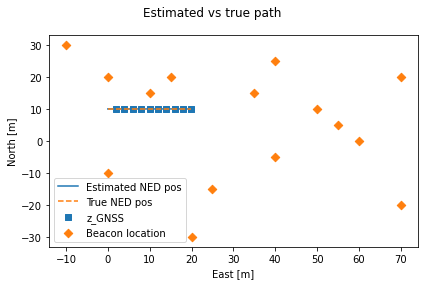

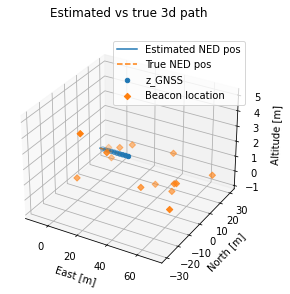

<Figure size 432x288 with 0 Axes>

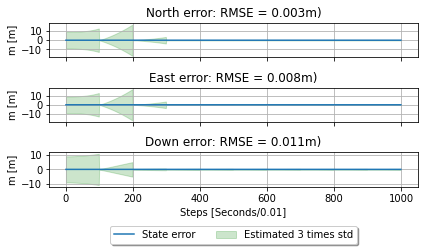

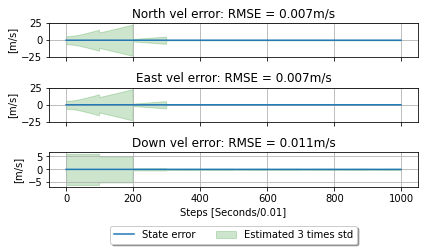

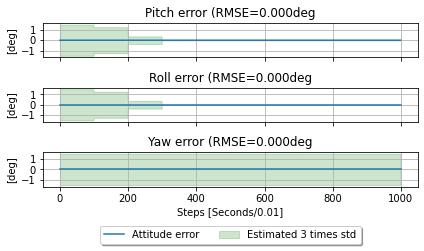

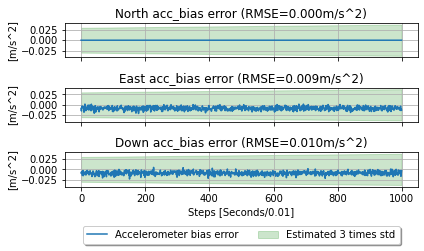

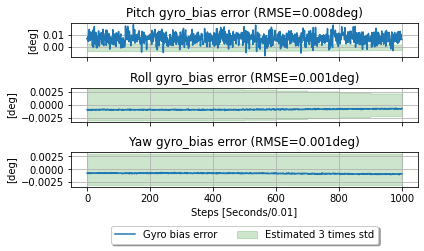

In [15]:
print("\nNumber of beacons used: ", num_beacons)
print("Number of simulations ran through", num_sims)
print("Simulation duration (seconds): ", N*dt) 

# %
if (use_batch_pseudoranges):
    for i in range(num_sims):  
        # timeit.timeit()
        print("\nUsing batch pseudoranges without factorization. Run number: ", i+1)
        
        t_batch[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        est_timer,
        pred_timer,
        elapsed_pred_timer_batch,
        elapsed_est_timer_batch
        ) = run_batch_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_batch[i] = time.time() - t_batch[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_batch[i] = np.sum(elapsed_pred_timer_batch)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_batch[i] = np.sum(elapsed_est_timer_batch)


    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path_batch',x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path3d_batch',x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'batch', 'error_pos_sigma_batch')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'batch', 'error_vel_sigma_batch')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'batch', 'error_att_sigma_batch')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_acc_bias_sigma_batch')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_rate_bias_sigma_batch')
    # Batch timings

In [16]:
    print("\nEllapsed time for batch: ", np.round(elapsed_batch,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_batch,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_batch/elapsed_batch*100,3), "%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_batch,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_batch/elapsed_batch*100,3), "%")

    average_time_batch = np.round(np.average(elapsed_batch),3)
    print("\nAverage time for batch elapsed: ", average_time_batch, "seconds")
    average_elapsed_pred_timer_batch = np.round(np.average(total_elapsed_pred_timer_batch),3)
    average_elapsed_est_timer_batch = np.round(np.average(total_elapsed_est_timer_batch),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_batch, ", where average occupies =", np.round(average_elapsed_pred_timer_batch/average_time_batch*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_batch, ", where average occupies =", np.round(average_elapsed_est_timer_batch/average_time_batch*100,3), "% " "relative to total time")


Ellapsed time for batch:  [2.357 2.182 1.897 1.907 2.138]
Summed runtime used in prediction module:  [2.289 2.138 1.839 1.852 2.081] seconds
Portion of runtime prediction module occupies:  [97.119 97.982 96.943 97.116 97.334] %
Summed runtime used in estimation module:  [0.015 0.014 0.017 0.017 0.017] seconds
Portion of runtime estimation module occupies:  [0.636 0.643 0.897 0.892 0.796] %

Average time for batch elapsed:  2.096 seconds
Average runtime for prediction module:  2.04 , where average occupies = 97.328 % relative to total time
Average runtime for estimation module:  0.016 , where average occupies = 0.763 % relative to total time



Using sequential pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 246.86it/s]



Using sequential pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 438.27it/s]



Using sequential pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 443.85it/s]



Using sequential pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 535.48it/s]



Using sequential pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 564.06it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent

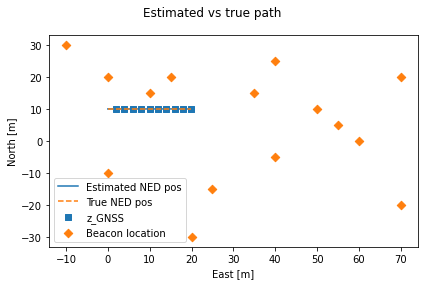

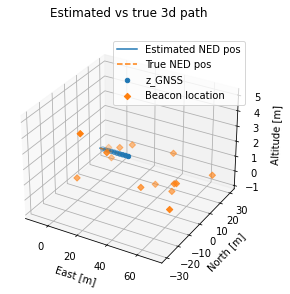

<Figure size 432x288 with 0 Axes>

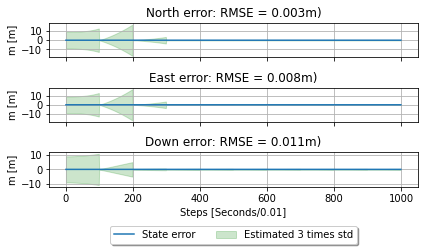

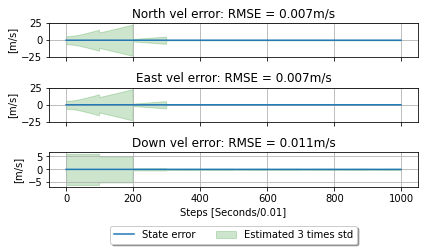

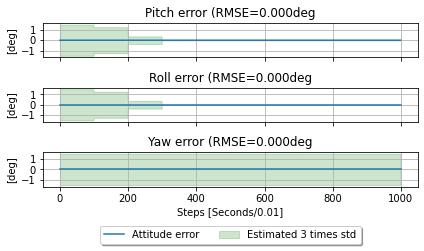

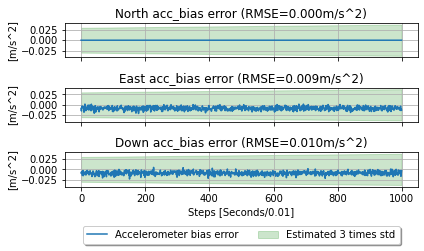

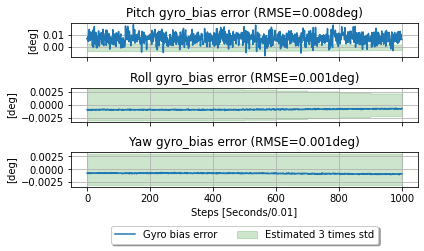

In [17]:
if (use_sequential_pseudoranges):
    for i in range(num_sims):
        print("\nUsing sequential pseudoranges without factorization. Run number: ", i+1)  
        # timeit.timeit()
        t_sequential[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_sequential,
        elapsed_est_timer_sequential
        ) = run_sequential_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
            
        elapsed_sequential[i] = time.time() - t_sequential[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_sequential[i] = np.sum(elapsed_pred_timer_sequential)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_sequential[i] = np.sum(elapsed_est_timer_sequential)

    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path_seq', x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path3d_seq', x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'sequential', 'error_pos_sigma_seq')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'sequential', 'error_vel_sigma_seq')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'sequential', 'error_att_sigma_seq')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_acc_bias_sigma_seq')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_rate_bias_sigma_seq')
    
    ## Sequential timings

In [18]:
    print("\nEllapsed time for sequential: ", np.round(elapsed_sequential,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_sequential,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_sequential/elapsed_sequential*100,3),"%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_sequential,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_sequential/elapsed_sequential*100,3),"%")
  

    average_time_sequential = np.round(np.average(elapsed_sequential),3)
    print("\nAverage time for sequential elapsed: ", average_time_sequential, "seconds")
    average_elapsed_pred_timer_sequential = np.round(np.average(total_elapsed_pred_timer_sequential),3)
    average_elapsed_est_timer_sequential = np.round(np.average(total_elapsed_est_timer_sequential),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_sequential, ", where average occupies =", np.round(average_elapsed_pred_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_sequential, ", where average occupies =", np.round(average_elapsed_est_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")


Ellapsed time for sequential:  [4.079 2.306 2.275 1.888 1.797]
Summed runtime used in prediction module:  [4.013 2.265 2.224 1.841 1.75 ] seconds
Portion of runtime prediction module occupies:  [98.383 98.222 97.759 97.512 97.386] %
Summed runtime used in estimation module:  [0.014 0.011 0.013 0.015 0.011] seconds
Portion of runtime estimation module occupies:  [0.343 0.479 0.572 0.795 0.612] %

Average time for sequential elapsed:  2.469 seconds
Average runtime for prediction module:  2.419 , where average occupies = 97.975 % relative to total time
Average runtime for estimation module:  0.013 , where average occupies = 0.527 % relative to total time


Using sequential pseudoranges with UDU Propagation. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 232.27it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:03<00:00, 257.52it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 239.44it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 241.42it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 234.06it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent

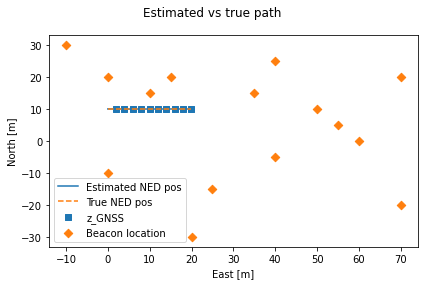

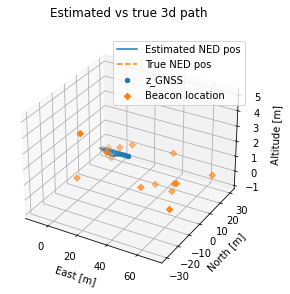

<Figure size 432x288 with 0 Axes>

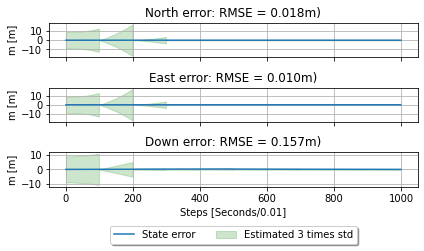

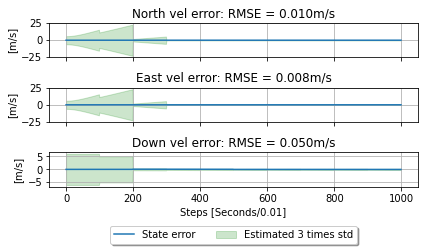

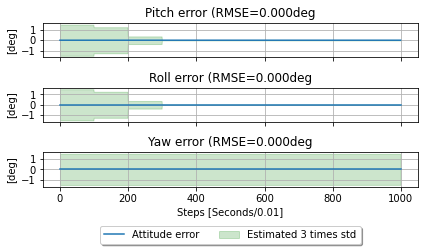

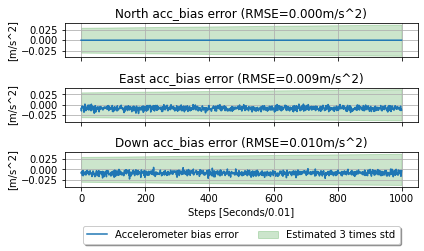

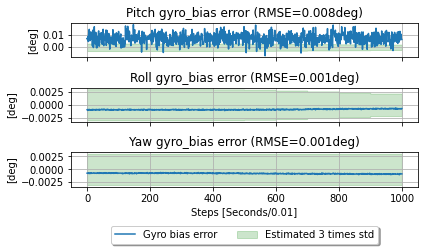

In [19]:
if (use_UDU):
    for i in range(num_sims):  
        # timeit.timeit()
        print("Using sequential pseudoranges with UDU Propagation. Run number: ", i+1)
        
        t_UDU[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_UDU,
        elapsed_est_timer_UDU
        ) = run_UDU_eskf (
                            N, loaded_data,
                            use_UDU,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_UDU[i] = time.time() - t_UDU[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_UDU[i] = np.sum(elapsed_pred_timer_UDU)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_UDU[i] = np.sum(elapsed_est_timer_UDU)
        
    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path_udu', x_true,)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path3d_udu', x_true,)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'udu', 'error_pos_sigma_udu')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'udu', 'error_vel_sigma_udu')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'udu', 'error_att_sigma_udu')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_acc_bias_sigma_udu')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_rate_bias_sigma_udu')
    ## UDU timings

In [20]:
    print("\nEllapsed time for UDU: ",  np.round(elapsed_UDU,3))
    print("Summed runtime used in UDU prediction module: ",  np.round(total_elapsed_pred_timer_UDU,3), "seconds")
    print("Portion of runtime prediction module in UDU occupies: ",  np.round(total_elapsed_pred_timer_UDU/elapsed_UDU,3),"%")
    print("Summed runtime used in UDU estimation module: ",  np.round(total_elapsed_est_timer_UDU,3), "seconds")
    print("Portion of runtime estimation module in UDU ccupies: ",  np.round(total_elapsed_est_timer_UDU/elapsed_UDU,3),"%")

    average_time_UDU = np.round(np.average(elapsed_UDU),3)
    print("\nAverage time for UDU elapsed: ", np.round(average_time_UDU,3), "seconds")
    average_elapsed_pred_timer_UDU = np.round(np.average(total_elapsed_pred_timer_UDU),3)
    average_elapsed_est_timer_UDU = np.round(np.average(total_elapsed_est_timer_UDU),3)
    print("Average runtime for prediction module in UDU: ", average_elapsed_pred_timer_UDU, ", where average occupies =",  np.round(average_elapsed_pred_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")
    print("Average runtime for estimation module in UDU: ", average_elapsed_est_timer_UDU, ", where average occupies =",  np.round(average_elapsed_est_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")


Ellapsed time for UDU:  [4.333 3.931 4.199 4.165 4.293]
Summed runtime used in UDU prediction module:  [4.063 3.628 3.938 3.911 4.033] seconds
Portion of runtime prediction module in UDU occupies:  [0.938 0.923 0.938 0.939 0.939] %
Summed runtime used in UDU estimation module:  [0.213 0.222 0.21  0.208 0.209] seconds
Portion of runtime estimation module in UDU ccupies:  [0.049 0.056 0.05  0.05  0.049] %

Average time for UDU elapsed:  4.184 seconds
Average runtime for prediction module in UDU:  3.915 , where average occupies = 93.571 % relative to total time
Average runtime for estimation module in UDU:  0.212 , where average occupies = 5.067 % relative to total time


In [21]:
## Relative relations
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of batch vs sequential: ",  np.round((average_time_batch - average_time_sequential)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_sequential)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_sequential)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs sequential:  -17.796 %
Average Relative speedup of pred module in batch vs sequential:  -18.578 %
Average Relative speedup of est module in batch vs sequential:  18.75 %


In [22]:
if (use_batch_pseudoranges & use_UDU):
    print("\nAverage Relative speedup of batch vs UDU-sequential: ",  np.round((average_time_batch - average_time_UDU)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs UDU-sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs UDU-sequential:  -99.618 %
Average Relative speedup of pred module in batch vs UDU-sequential:  -91.912 %
Average Relative speedup of est module in batch vs UDU-sequential:  -1225.0 %


In [23]:
if (use_UDU & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of sequential vs UDU-sequential: ",  np.round((average_time_sequential - average_time_UDU)/average_time_sequential*100,3),"%")
    print("Average Relative speedup of pred module in sequential vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_sequential - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_sequential*100,3), "%")
    print("Average Relative speedup of est module in  sequential vs UDU-sequential: ",  np.round((average_elapsed_est_timer_sequential - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_sequential*100,3), "%")


Average Relative speedup of sequential vs UDU-sequential:  -69.461 %
Average Relative speedup of pred module in sequential vs UDU-sequential:  -61.844 %
Average Relative speedup of est module in  sequential vs UDU-sequential:  -1530.769 %


ValueError: dictionary update sequence element #0 has length 1; 2 is required

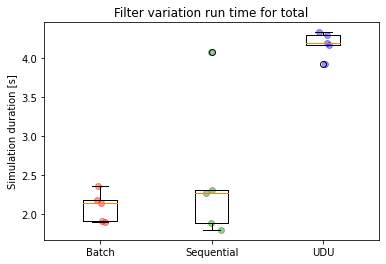

In [24]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                

ValueError: dictionary update sequence element #0 has length 1; 2 is required

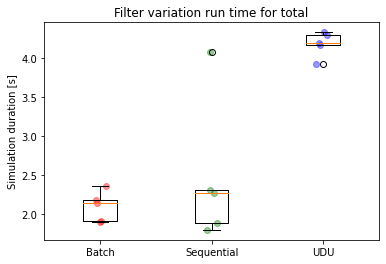

In [25]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                

ValueError: dictionary update sequence element #0 has length 1; 2 is required

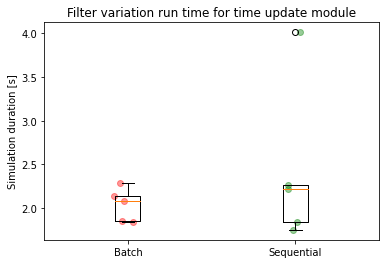

In [26]:
plot_timing_scatter2('timing10','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)

ValueError: dictionary update sequence element #0 has length 1; 2 is required

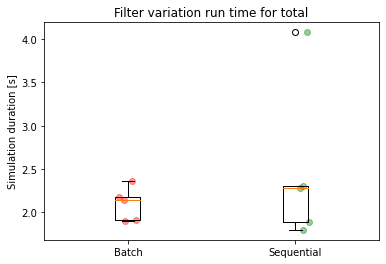

In [27]:
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)

In [28]:
def plot_timing_scatter(location, figname, plot_title, batch_time = None, seq_time = None, udu_time = None):
    fig = plt.figure()
    n = len(batch_time)
    labels = ['Batch', 'Sequential', 'UDU']
    all_data = np.zeros((n,3))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    all_data[:,2] = udu_time
    
    avg_data = np.zeros(3)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)
    avg_data[2] = np.round(np.average(all_data[:,2]),2)
    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Simulation duration [s]')
    plt.title('Filter variation run time for 'f"{plot_title}", 'n = ' f"{n}")
    plt.legend(['Batch average: 'f"{avg_data[0]}" '[s]', 'Seq average: 'f"{avg_data[1]}" '[s]', 'UDU average: 'f"{avg_data[2]}" '[s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')

ValueError: dictionary update sequence element #0 has length 1; 2 is required

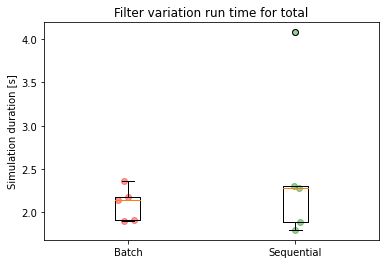

In [29]:
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)

In [30]:
def plot_timing_scatter(location, figname, plot_title, batch_time = None, seq_time = None, udu_time = None):
    fig = plt.figure()
    n = len(batch_time)
    labels = ['Batch', 'Sequential', 'UDU']
    all_data = np.zeros((n,3))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    all_data[:,2] = udu_time
    
    avg_data = np.zeros(3)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)
    avg_data[2] = np.round(np.average(all_data[:,2]),2)
    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Simulation duration [s]')
    plt.title('Filter variation run time for 'f"{plot_title}")
    plt.legend(['Batch average: 'f"{avg_data[0]}" '[s]', 'Seq average: 'f"{avg_data[1]}" '[s]', 'UDU average: 'f"{avg_data[2]}" '[s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')

ValueError: dictionary update sequence element #0 has length 1; 2 is required

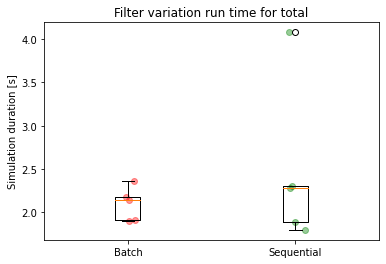

In [31]:
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

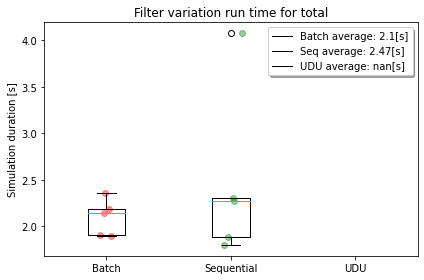

In [32]:
        plot_timing_scatter('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)

In [33]:
        plot_timing_scatter('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_udu)

NameError: name 'elapsed_udu' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

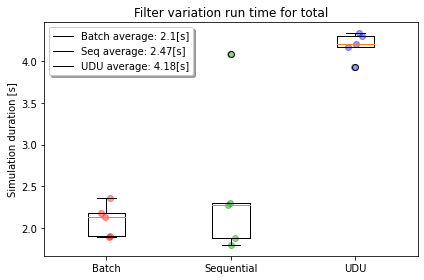

In [34]:
        plot_timing_scatter('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)

In [35]:
def plot_timing_scatter(location, figname, plot_title, batch_time = None, seq_time = None, udu_time = None):
    fig = plt.figure()
    n = len(batch_time)
    labels = ['Batch', 'Sequential', 'UDU']
    all_data = np.zeros((n,3))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    all_data[:,2] = udu_time
    
    avg_data = np.zeros(3)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)
    avg_data[2] = np.round(np.average(all_data[:,2]),2)
    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Simulation duration [s]')
    plt.title('Filter variation run time for 'f"{plot_title}", 'n = 'f"{n}")
    plt.legend(['Batch average: 'f"{avg_data[0]}" '[s]', 'Seq average: 'f"{avg_data[1]}" '[s]', 'UDU average: 'f"{avg_data[2]}" '[s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')

ValueError: dictionary update sequence element #0 has length 1; 2 is required

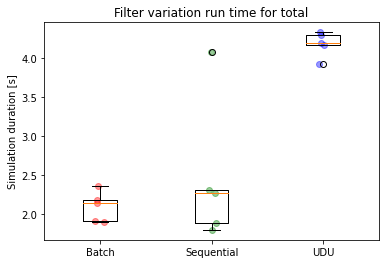

In [36]:
        plot_timing_scatter('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)

In [37]:
def plot_timing_scatter(location, figname, plot_title, batch_time = None, seq_time = None, udu_time = None):
    fig = plt.figure()
    n = len(batch_time)
    labels = ['Batch', 'Sequential', 'UDU']
    all_data = np.zeros((n,3))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    all_data[:,2] = udu_time
    
    avg_data = np.zeros(3)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)
    avg_data[2] = np.round(np.average(all_data[:,2]),2)
    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Simulation duration [s]')
    plt.title('Filter variation run time for 'f"{plot_title}"'n = 'f"{n}")
    plt.legend(['Batch average: 'f"{avg_data[0]}" '[s]', 'Seq average: 'f"{avg_data[1]}" '[s]', 'UDU average: 'f"{avg_data[2]}" '[s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

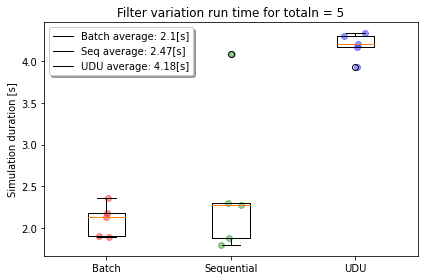

In [38]:
        plot_timing_scatter('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)

In [39]:
def plot_timing_scatter(location, figname, plot_title, batch_time = None, seq_time = None, udu_time = None):
    fig = plt.figure()
    n = len(batch_time)
    labels = ['Batch', 'Sequential', 'UDU']
    all_data = np.zeros((n,3))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    all_data[:,2] = udu_time
    
    avg_data = np.zeros(3)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)
    avg_data[2] = np.round(np.average(all_data[:,2]),2)
    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Simulation duration [s]')
    plt.title('Filter variation run time for 'f"{plot_title}"', n = 'f"{n}")
    plt.legend(['Batch average: 'f"{avg_data[0]}"' [s]', 'Seq average: 'f"{avg_data[1]}"' [s]', 'UDU average: 'f"{avg_data[2]}"' [s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')
    
def plot_timing_scatter2(location, figname, plot_title, batch_time = None, seq_time = None):
    fig = plt.figure()
    
    n = len(batch_time)
    labels = ['Batch', 'Sequential']
    all_data = np.zeros((n,2))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    
    avg_data = np.zeros(2)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)

    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Simulation duration [s]')
    plt.title('Filter variation run time for 'f"{plot_title}"', n = 'f"{n}")
    plt.legend(['Batch average: 'f"{avg_data[0]}"' [s]', 'Seq average: 'f"{avg_data[1]}"' [s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

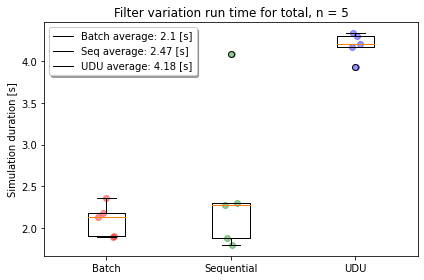

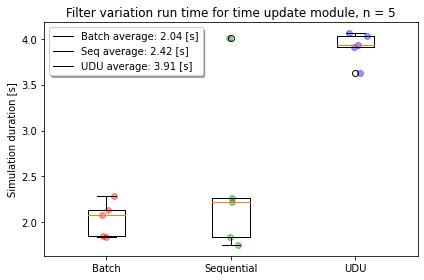

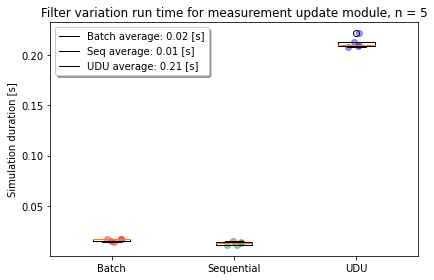

In [40]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

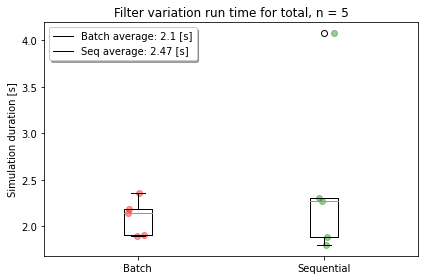

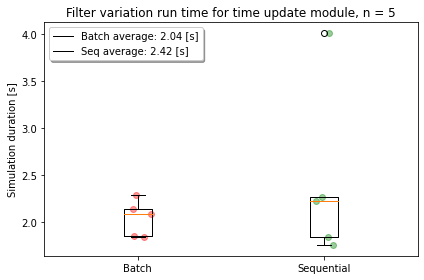

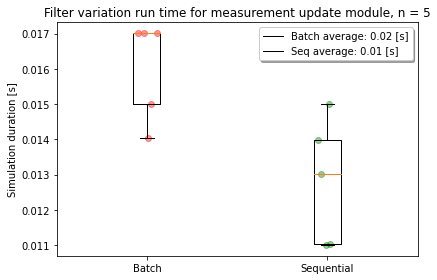

In [41]:
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    if (N ==10/dt):
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing10','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing10','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==100/dt):
        plot_timing_scatter2('timing100','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing100','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing100','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==600/dt):
        plot_timing_scatter2('timing600','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing600','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing600','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==1000/dt):
        plot_timing_scatter2('timing1000','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing1000','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing1000','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                

In [42]:
def plot_timing_scatter(location, figname, plot_title, batch_time = None, seq_time = None, udu_time = None):
    fig = plt.figure()
    n = len(batch_time)
    labels = ['Batch', 'Sequential', 'UDU']
    all_data = np.zeros((n,3))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    all_data[:,2] = udu_time
    
    avg_data = np.zeros(3)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)
    avg_data[2] = np.round(np.average(all_data[:,2]),2)
    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Elapsed run time [s]')
    plt.grid()
    plt.title('Filter variation run time for 'f"{plot_title}"', n = 'f"{n}")
    plt.legend(['Batch average: 'f"{avg_data[0]}"' [s]', 'Seq average: 'f"{avg_data[1]}"' [s]', 'UDU average: 'f"{avg_data[2]}"' [s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')
    
def plot_timing_scatter2(location, figname, plot_title, batch_time = None, seq_time = None):
    fig = plt.figure()
    
    n = len(batch_time)
    labels = ['Batch', 'Sequential']
    all_data = np.zeros((n,2))
    all_data[:,0] = batch_time
    all_data[:,1] = seq_time
    
    avg_data = np.zeros(2)
    avg_data[0] = np.round(np.average(all_data[:,0]),2)
    avg_data[1] = np.round(np.average(all_data[:,1]),2)

    
    df = pd.DataFrame(all_data, columns=labels)
  
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    # colors = ["crimson", "purple", "limegreen"]
    plt.boxplot(vals, labels=names)
    palette = ['r', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
            
    plt.ylabel('Elapsed run time [s]')
    plt.grid()
    plt.title('Filter variation run time for 'f"{plot_title}"', n = 'f"{n}")
    plt.legend(['Batch average: 'f"{avg_data[0]}"' [s]', 'Seq average: 'f"{avg_data[1]}"' [s]'],loc='best', fancybox=True, shadow=True)
    fig.tight_layout()
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.eps')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.png')
    plt.savefig('../plots/'f"{location}"'/'f"{figname}"'.pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

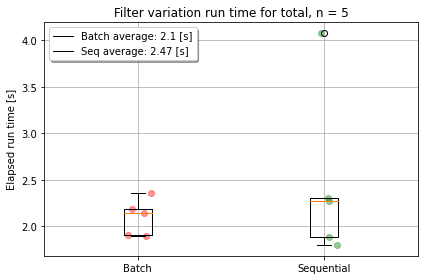

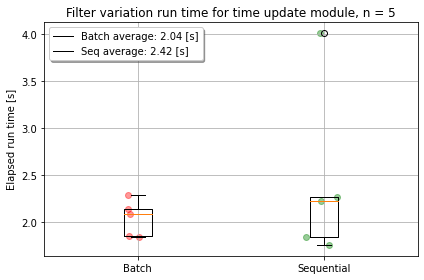

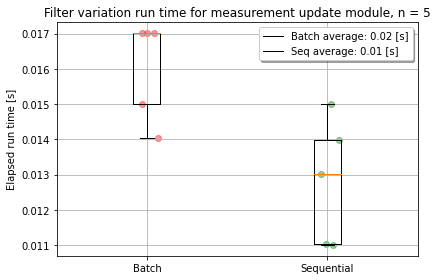

In [43]:
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    if (N ==10/dt):
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing10','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing10','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==100/dt):
        plot_timing_scatter2('timing100','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing100','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing100','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==600/dt):
        plot_timing_scatter2('timing600','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing600','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing600','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==1000/dt):
        plot_timing_scatter2('timing1000','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing1000','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing1000','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

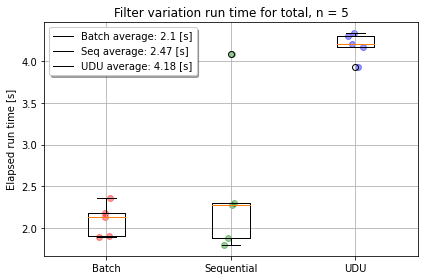

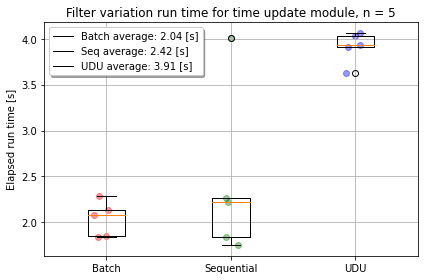

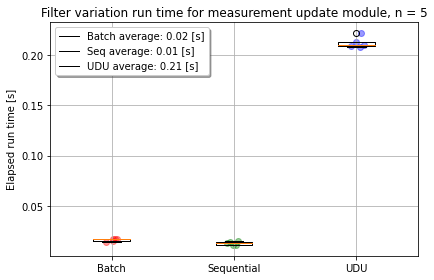

In [44]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                

In [1]:
from plotter import plot_NEES, plot_NIS, plot_angle, plot_error_pos_sigma, plot_error_vel_sigma, plot_path, state_error_plots
from typing import Tuple, Sequence, Any
from matplotlib import pyplot as plt


# from plotfunctionstesting import plot_acc, plot_acc2, plot_gyro, plot_angle

import numpy as np
import scipy.linalg as la
import scipy
import scipy.io
import scipy.stats
from dataclasses import dataclass, field
import timeit
import time

import tqdm
import os
import sys

from tqdm import trange
from tqdm import tqdm_notebook

from quaternion import * 
from cat_slice import CatSlice
# from eskf import ESKF
# from eskf import ESKF

from utils import UDU_factorization

from eskf_batch import ESKF_batch
from eskf_sequential import ESKF_sequential
from eskf_UDU import ESKF_udu
from eskf_runner import run_batch_eskf, run_sequential_eskf, run_UDU_eskf
from plotter import * #plot_error_v_sigma, plot_pos, plot_vel, plot_angle, plot_estimate, plot_3Dpath, plot_path, state_error_plots, plot_NEES, plot_NIS
# from timer import * 

In [2]:
plt.close('all')

from plot_setup import setup_plot
setup_plot()
np.seterr(all='raise')
scipy.special.seterr(all='raise')

matplotlib backend: module://matplotlib_inline.backend_inline
matplotlib config file: C:\Python39\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\Users\Andreas\.matplotlib
Plotting is set to inline at the moment: unknown inline backend
continuing with this plotting backend


pyplot using style set ['science', 'grid', 'no-latex']


{'singular': 'ignore',
 'underflow': 'ignore',
 'overflow': 'ignore',
 'slow': 'ignore',
 'loss': 'ignore',
 'no_result': 'ignore',
 'domain': 'ignore',
 'arg': 'ignore',
 'other': 'ignore'}

In [3]:
"""
Q_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std
R: p_std -> R_GNSS = p_std**2*eye(3)
"""

'\nQ_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std\nR: p_std -> R_GNSS = p_std**2*eye(3)\n'

In [4]:
"""
Loads true state, time steps and other simulation variables. Run gen_mat to generate
new data
"""

folder = os.path.dirname(__file__)
# filename_to_load = f"{folder}/../data/simulation_params.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver2.mat"
filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver3.mat"
cache_folder = os.path.join(folder,'..', 'cache')
loaded_data = scipy.io.loadmat(filename_to_load)

timeIMU = loaded_data["timeIMU"].ravel()
#acc_t = loaded_data["acc_t"].T
if 'x_true' in loaded_data:
    x_true = loaded_data["x_true"].T
else:
    x_true = None
# z_GNSS = loaded_data["z_GNSS"].T
    
beacon_location = loaded_data["beacon_location"]

tGNSS = loaded_data["timeGNSS"].T
z_GNSS = loaded_data["z_GNSS"].T

z_acc_vector = loaded_data["z_acc"].T
acc_t = loaded_data["acc_t"].T
omega_t = loaded_data["omega_t"].T
z_gyro_vector = loaded_data["z_gyro"].T

dt = np.mean(np.diff(timeIMU))

In [5]:
POS_IDX = CatSlice(start=0, stop=3)
VEL_IDX = CatSlice(start=3, stop=6)
ATT_IDX = CatSlice(start=6, stop=10)
ACC_BIAS_IDX = CatSlice(start=10, stop=13)
GYRO_BIAS_IDX = CatSlice(start=13, stop=16)

ERR_ATT_IDX = CatSlice(start=6, stop=9)
ERR_ACC_BIAS_IDX = CatSlice(start=9, stop=12)
ERR_GYRO_BIAS_IDX = CatSlice(start=12, stop=15)

In [6]:
# Initializing prediction
x_pred_init = np.zeros(16)

# 8 figure init
x_pred_init[POS_IDX] = np.array([10,0,1])
x_pred_init[VEL_IDX] = np.array([0, 2, 0])
x_pred_init[6:10] = np.array([1,0,0,0]) #(0,0,0) iny euler
# x_pred_init[10:13] = np.array([-8.75e-2,-8.74e-2,6.9e-2])
# x_pred_init[13:16] = np.array([-9.54e-4,-7.32e-04,3.37e-04])

# x_pred_init[POS_IDX] = np.array([0, 0, -5])  # starting 5 metres above ground
# x_pred_init[VEL_IDX] = np.array([20, 0, 0])  # starting at 20 m/s due north
# no initial rotation: nose to North, right to East, and belly down
# x_pred_init[6] = 1

In [7]:
# acc_std = 7.59562072e-02
# rate_std =  5.12679127e-02

# cont_acc_bias_driving_noise_std =  1.16562328e-04
# cont_rate_bias_driving_noise_std =  1.94631260e-05

In [8]:
# TUNABLE0.01035
# cont_gyro_noise_std =  0.01035
cont_gyro_noise_std =   4.36e-5  # (rad/s)/sqrt(Hz)
# TUNABLE 0.015191 
# cont_acc_noise_std = np.array([0.01, 0.01, 0.042191])
# cont_acc_noise_std = 0.01549 #1.167e-2  # (m/s**2)/sqrt(Hz)
cont_acc_noise_std =  1.167e-2  # (m/s**2)/sqrt(Hz)

# cont_gyro_noise_std = 0.001      #4.36e-5  # (rad/s)/sqrt(Hz)
# cont_acc_noise_std = 0.001  #1.167e-3  # (m/s**2)/sqrt(Hz)

# Discrete sample noise at simulation rate used
# This is the formula from example 4.9. Should this be the driving noise instead?
rate_std = np.round(0.5 * cont_gyro_noise_std * np.sqrt(1 / dt),7) #Just to avoid float shit
acc_std = np.round(0.5 * cont_acc_noise_std * np.sqrt(1 / dt),7)

# Bias values
# TUNABLE 0.0005839  0.00005839 
# 5e-5 From another simulation
rate_bias_driving_noise_std =  5e-5 

cont_rate_bias_driving_noise_std = (
    np.round((1 / 3) * rate_bias_driving_noise_std / np.sqrt(1 / dt), 7)
)
#4e-3 From another simulation
#0.0001947, 0.0020947 0.0050947
acc_bias_driving_noise_std = 4e-3
cont_acc_bias_driving_noise_std = 6 * acc_bias_driving_noise_std / np.sqrt(1 / dt)

In [9]:
p_acc =   1.000e-6
p_gyro = 1.00000000e-6

In [10]:
# p_std = np.array([1.58170828, 1.58170828, 0.97243219])   # Measurement noise

#The measurements from the GNSS are perfect at the moment
# p_std = np.array([0, 0, 0])
p_std = np.array([.01, .01, .03])
# p_std = np.array([.1, .1, .3])
# p_std = np.array([.3, .3, .5])

In [11]:
P_pred_init = np.zeros((15,15))
P_pred_init[POS_IDX ** 2] = np.eye(3) * 3**2  
P_pred_init[VEL_IDX ** 2] = np.eye(3) * 2**2  #0.2
P_pred_init[ERR_ATT_IDX ** 2] = np.eye(3) * 0.5**2  # TODO
P_pred_init[ERR_ACC_BIAS_IDX ** 2] = np.eye(3) * 0.01**2 
P_pred_init[ERR_GYRO_BIAS_IDX ** 2] = np.eye(3) * 0.001**2 # 0.001**2 
 
eskf_parameters = [acc_std,
                    rate_std,
                    cont_acc_bias_driving_noise_std,
                    cont_rate_bias_driving_noise_std,
                    p_acc,
                    p_gyro]   

In [12]:
#Number of seconds of simulation to run. len(timeIMU) decides max
# N: int = int(1000/dt)
N: int = int(10/dt) 
# N: int = int(600/dt) 
# N: int = int(90000)
# N: int = len(timeIMU)
offset = 0
doGNSS: bool = True
# rtol = 1e-05
# atol = 1e-08

In [13]:
# plt.close("all")
t = np.linspace(0,dt * (N-1), N)
# plot_path(t, N, pos_t, pos_t)

In [14]:
"""
Running the simulation
"""
beacon_location: np.ndarray = loaded_data["beacon_location"]

use_batch_pseudoranges: bool = True
# use_batch_pseudoranges: bool = False
use_sequential_pseudoranges: bool = True
# use_sequential_pseudoranges: bool = False
use_UDU: bool = True
# use_UDU: bool = False

num_beacons = len(beacon_location)
num_sims = 100

#Timers for batch-filter
t_batch = np.zeros(num_sims)
elapsed_batch = np.zeros(num_sims)

#Timers for sequential filter
t_sequential = np.zeros(num_sims)
elapsed_sequential = np.zeros(num_sims)

#Timers for UDU filter
t_UDU = np.zeros(num_sims)
elapsed_UDU = np.zeros(num_sims)

#Timers for submodules
total_elapsed_pred_timer_batch = np.zeros(num_sims)
total_elapsed_est_timer_batch = np.zeros(num_sims)
average_elapsed_pred_timer_batch = np.zeros(num_sims)
average_elapsed_est_timer_batch = np.zeros(num_sims)

total_elapsed_pred_timer_sequential = np.zeros(num_sims)
total_elapsed_est_timer_sequential = np.zeros(num_sims)
average_elapsed_pred_timer_sequential = np.zeros(num_sims)
average_elapsed_est_timer_sequential = np.zeros(num_sims)

total_elapsed_pred_timer_UDU = np.zeros(num_sims)
total_elapsed_est_timer_UDU = np.zeros(num_sims)
average_elapsed_pred_timer_UDU = np.zeros(num_sims)
average_elapsed_est_timer_UDU = np.zeros(num_sims)

In [15]:
print("\nNumber of beacons used: ", num_beacons)
print("Number of simulations ran through", num_sims)
print("Simulation duration (seconds): ", N*dt) 

# %
if (use_batch_pseudoranges):
    for i in range(num_sims):  
        # timeit.timeit()
        print("\nUsing batch pseudoranges without factorization. Run number: ", i+1)
        
        t_batch[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        est_timer,
        pred_timer,
        elapsed_pred_timer_batch,
        elapsed_est_timer_batch
        ) = run_batch_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_batch[i] = time.time() - t_batch[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_batch[i] = np.sum(elapsed_pred_timer_batch)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_batch[i] = np.sum(elapsed_est_timer_batch)


    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path_batch',x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path3d_batch',x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'batch', 'error_pos_sigma_batch')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'batch', 'error_vel_sigma_batch')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'batch', 'error_att_sigma_batch')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_acc_bias_sigma_batch')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_rate_bias_sigma_batch')
    # Batch timings


Number of beacons used:  15
Number of simulations ran through 100
Simulation duration (seconds):  10.0

Using batch pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 389.47it/s]



Using batch pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 571.83it/s]



Using batch pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 444.75it/s]



Using batch pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 516.33it/s]



Using batch pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 381.21it/s]



Using batch pseudoranges without factorization. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


  5%|▌         | 50/1000 [00:00<00:02, 442.89it/s]


KeyboardInterrupt: 

In [16]:
from plotter import plot_NEES, plot_NIS, plot_angle, plot_error_pos_sigma, plot_error_vel_sigma, plot_path, state_error_plots
from typing import Tuple, Sequence, Any
from matplotlib import pyplot as plt


# from plotfunctionstesting import plot_acc, plot_acc2, plot_gyro, plot_angle

import numpy as np
import scipy.linalg as la
import scipy
import scipy.io
import scipy.stats
from dataclasses import dataclass, field
import timeit
import time

import tqdm
import os
import sys

from tqdm import trange
from tqdm import tqdm_notebook

from quaternion import * 
from cat_slice import CatSlice
# from eskf import ESKF
# from eskf import ESKF

from utils import UDU_factorization

from eskf_batch import ESKF_batch
from eskf_sequential import ESKF_sequential
from eskf_UDU import ESKF_udu
from eskf_runner import run_batch_eskf, run_sequential_eskf, run_UDU_eskf
from plotter import * #plot_error_v_sigma, plot_pos, plot_vel, plot_angle, plot_estimate, plot_3Dpath, plot_path, state_error_plots, plot_NEES, plot_NIS
# from timer import * 

In [17]:
plt.close('all')

from plot_setup import setup_plot
setup_plot()
np.seterr(all='raise')
scipy.special.seterr(all='raise')

matplotlib backend: module://matplotlib_inline.backend_inline
matplotlib config file: C:\Python39\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\Users\Andreas\.matplotlib
Plotting is set to inline at the moment: unknown inline backend
continuing with this plotting backend


pyplot using style set ['science', 'grid', 'no-latex']


{'singular': 'raise',
 'underflow': 'raise',
 'overflow': 'raise',
 'slow': 'raise',
 'loss': 'raise',
 'no_result': 'raise',
 'domain': 'raise',
 'arg': 'raise',
 'other': 'raise'}

In [18]:
"""
Q_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std
R: p_std -> R_GNSS = p_std**2*eye(3)
"""

'\nQ_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std\nR: p_std -> R_GNSS = p_std**2*eye(3)\n'

In [19]:
"""
Loads true state, time steps and other simulation variables. Run gen_mat to generate
new data
"""

folder = os.path.dirname(__file__)
# filename_to_load = f"{folder}/../data/simulation_params.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver2.mat"
filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver3.mat"
cache_folder = os.path.join(folder,'..', 'cache')
loaded_data = scipy.io.loadmat(filename_to_load)

timeIMU = loaded_data["timeIMU"].ravel()
#acc_t = loaded_data["acc_t"].T
if 'x_true' in loaded_data:
    x_true = loaded_data["x_true"].T
else:
    x_true = None
# z_GNSS = loaded_data["z_GNSS"].T
    
beacon_location = loaded_data["beacon_location"]

tGNSS = loaded_data["timeGNSS"].T
z_GNSS = loaded_data["z_GNSS"].T

z_acc_vector = loaded_data["z_acc"].T
acc_t = loaded_data["acc_t"].T
omega_t = loaded_data["omega_t"].T
z_gyro_vector = loaded_data["z_gyro"].T

dt = np.mean(np.diff(timeIMU))

In [20]:
POS_IDX = CatSlice(start=0, stop=3)
VEL_IDX = CatSlice(start=3, stop=6)
ATT_IDX = CatSlice(start=6, stop=10)
ACC_BIAS_IDX = CatSlice(start=10, stop=13)
GYRO_BIAS_IDX = CatSlice(start=13, stop=16)

ERR_ATT_IDX = CatSlice(start=6, stop=9)
ERR_ACC_BIAS_IDX = CatSlice(start=9, stop=12)
ERR_GYRO_BIAS_IDX = CatSlice(start=12, stop=15)

In [21]:
# Initializing prediction
x_pred_init = np.zeros(16)

# 8 figure init
x_pred_init[POS_IDX] = np.array([10,0,1])
x_pred_init[VEL_IDX] = np.array([0, 2, 0])
x_pred_init[6:10] = np.array([1,0,0,0]) #(0,0,0) iny euler
# x_pred_init[10:13] = np.array([-8.75e-2,-8.74e-2,6.9e-2])
# x_pred_init[13:16] = np.array([-9.54e-4,-7.32e-04,3.37e-04])

# x_pred_init[POS_IDX] = np.array([0, 0, -5])  # starting 5 metres above ground
# x_pred_init[VEL_IDX] = np.array([20, 0, 0])  # starting at 20 m/s due north
# no initial rotation: nose to North, right to East, and belly down
# x_pred_init[6] = 1

In [22]:
# acc_std = 7.59562072e-02
# rate_std =  5.12679127e-02

# cont_acc_bias_driving_noise_std =  1.16562328e-04
# cont_rate_bias_driving_noise_std =  1.94631260e-05

In [23]:
# TUNABLE0.01035
# cont_gyro_noise_std =  0.01035
cont_gyro_noise_std =   4.36e-5  # (rad/s)/sqrt(Hz)
# TUNABLE 0.015191 
# cont_acc_noise_std = np.array([0.01, 0.01, 0.042191])
# cont_acc_noise_std = 0.01549 #1.167e-2  # (m/s**2)/sqrt(Hz)
cont_acc_noise_std =  1.167e-2  # (m/s**2)/sqrt(Hz)

# cont_gyro_noise_std = 0.001      #4.36e-5  # (rad/s)/sqrt(Hz)
# cont_acc_noise_std = 0.001  #1.167e-3  # (m/s**2)/sqrt(Hz)

# Discrete sample noise at simulation rate used
# This is the formula from example 4.9. Should this be the driving noise instead?
rate_std = np.round(0.5 * cont_gyro_noise_std * np.sqrt(1 / dt),7) #Just to avoid float shit
acc_std = np.round(0.5 * cont_acc_noise_std * np.sqrt(1 / dt),7)

# Bias values
# TUNABLE 0.0005839  0.00005839 
# 5e-5 From another simulation
rate_bias_driving_noise_std =  5e-5 

cont_rate_bias_driving_noise_std = (
    np.round((1 / 3) * rate_bias_driving_noise_std / np.sqrt(1 / dt), 7)
)
#4e-3 From another simulation
#0.0001947, 0.0020947 0.0050947
acc_bias_driving_noise_std = 4e-3
cont_acc_bias_driving_noise_std = 6 * acc_bias_driving_noise_std / np.sqrt(1 / dt)

In [24]:
p_acc =   1.000e-6
p_gyro = 1.00000000e-6

In [25]:
# p_std = np.array([1.58170828, 1.58170828, 0.97243219])   # Measurement noise

#The measurements from the GNSS are perfect at the moment
# p_std = np.array([0, 0, 0])
p_std = np.array([.01, .01, .03])
# p_std = np.array([.1, .1, .3])
# p_std = np.array([.3, .3, .5])

In [26]:
P_pred_init = np.zeros((15,15))
P_pred_init[POS_IDX ** 2] = np.eye(3) * 3**2  
P_pred_init[VEL_IDX ** 2] = np.eye(3) * 2**2  #0.2
P_pred_init[ERR_ATT_IDX ** 2] = np.eye(3) * 0.5**2  # TODO
P_pred_init[ERR_ACC_BIAS_IDX ** 2] = np.eye(3) * 0.01**2 
P_pred_init[ERR_GYRO_BIAS_IDX ** 2] = np.eye(3) * 0.001**2 # 0.001**2 
 
eskf_parameters = [acc_std,
                    rate_std,
                    cont_acc_bias_driving_noise_std,
                    cont_rate_bias_driving_noise_std,
                    p_acc,
                    p_gyro]   

In [27]:
#Number of seconds of simulation to run. len(timeIMU) decides max
# N: int = int(1000/dt)
N: int = int(10/dt) 
# N: int = int(600/dt) 
# N: int = int(90000)
# N: int = len(timeIMU)
offset = 0
doGNSS: bool = True
# rtol = 1e-05
# atol = 1e-08

In [28]:
# plt.close("all")
t = np.linspace(0,dt * (N-1), N)
# plot_path(t, N, pos_t, pos_t)

In [29]:
"""
Running the simulation
"""
beacon_location: np.ndarray = loaded_data["beacon_location"]

use_batch_pseudoranges: bool = True
# use_batch_pseudoranges: bool = False
use_sequential_pseudoranges: bool = True
# use_sequential_pseudoranges: bool = False
use_UDU: bool = True
# use_UDU: bool = False

num_beacons = len(beacon_location)
num_sims = 100

#Timers for batch-filter
t_batch = np.zeros(num_sims)
elapsed_batch = np.zeros(num_sims)

#Timers for sequential filter
t_sequential = np.zeros(num_sims)
elapsed_sequential = np.zeros(num_sims)

#Timers for UDU filter
t_UDU = np.zeros(num_sims)
elapsed_UDU = np.zeros(num_sims)

#Timers for submodules
total_elapsed_pred_timer_batch = np.zeros(num_sims)
total_elapsed_est_timer_batch = np.zeros(num_sims)
average_elapsed_pred_timer_batch = np.zeros(num_sims)
average_elapsed_est_timer_batch = np.zeros(num_sims)

total_elapsed_pred_timer_sequential = np.zeros(num_sims)
total_elapsed_est_timer_sequential = np.zeros(num_sims)
average_elapsed_pred_timer_sequential = np.zeros(num_sims)
average_elapsed_est_timer_sequential = np.zeros(num_sims)

total_elapsed_pred_timer_UDU = np.zeros(num_sims)
total_elapsed_est_timer_UDU = np.zeros(num_sims)
average_elapsed_pred_timer_UDU = np.zeros(num_sims)
average_elapsed_est_timer_UDU = np.zeros(num_sims)


Number of beacons used:  15
Number of simulations ran through 100
Simulation duration (seconds):  10.0

Using batch pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 375.34it/s]



Using batch pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 460.80it/s]



Using batch pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 505.43it/s]



Using batch pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 561.92it/s]



Using batch pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 526.15it/s]



Using batch pseudoranges without factorization. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 420.34it/s]



Using batch pseudoranges without factorization. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 427.59it/s]



Using batch pseudoranges without factorization. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 412.08it/s]



Using batch pseudoranges without factorization. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 435.10it/s]



Using batch pseudoranges without factorization. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 402.02it/s]



Using batch pseudoranges without factorization. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 421.84it/s]



Using batch pseudoranges without factorization. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 403.99it/s]



Using batch pseudoranges without factorization. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 435.55it/s]



Using batch pseudoranges without factorization. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 405.27it/s]



Using batch pseudoranges without factorization. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 402.27it/s]



Using batch pseudoranges without factorization. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 426.89it/s]



Using batch pseudoranges without factorization. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 418.87it/s]



Using batch pseudoranges without factorization. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 424.95it/s]



Using batch pseudoranges without factorization. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 429.18it/s]



Using batch pseudoranges without factorization. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 433.93it/s]



Using batch pseudoranges without factorization. Run number:  21
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 439.01it/s]



Using batch pseudoranges without factorization. Run number:  22
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 430.03it/s]



Using batch pseudoranges without factorization. Run number:  23
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 429.69it/s]



Using batch pseudoranges without factorization. Run number:  24
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 431.89it/s]



Using batch pseudoranges without factorization. Run number:  25
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.37it/s]



Using batch pseudoranges without factorization. Run number:  26
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.50it/s]



Using batch pseudoranges without factorization. Run number:  27
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 428.78it/s]



Using batch pseudoranges without factorization. Run number:  28
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 411.86it/s]



Using batch pseudoranges without factorization. Run number:  29
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 410.92it/s]



Using batch pseudoranges without factorization. Run number:  30
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 413.02it/s]



Using batch pseudoranges without factorization. Run number:  31
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 400.79it/s]



Using batch pseudoranges without factorization. Run number:  32
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 413.31it/s]



Using batch pseudoranges without factorization. Run number:  33
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 398.81it/s]



Using batch pseudoranges without factorization. Run number:  34
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 397.28it/s]



Using batch pseudoranges without factorization. Run number:  35
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 398.39it/s]



Using batch pseudoranges without factorization. Run number:  36
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 419.76it/s]



Using batch pseudoranges without factorization. Run number:  37
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.44it/s]



Using batch pseudoranges without factorization. Run number:  38
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 424.46it/s]



Using batch pseudoranges without factorization. Run number:  39
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 442.45it/s]



Using batch pseudoranges without factorization. Run number:  40
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 480.25it/s]



Using batch pseudoranges without factorization. Run number:  41
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 407.00it/s]



Using batch pseudoranges without factorization. Run number:  42
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 427.07it/s]



Using batch pseudoranges without factorization. Run number:  43
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 410.25it/s]



Using batch pseudoranges without factorization. Run number:  44
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 431.21it/s]



Using batch pseudoranges without factorization. Run number:  45
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 416.15it/s]



Using batch pseudoranges without factorization. Run number:  46
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 427.53it/s]



Using batch pseudoranges without factorization. Run number:  47
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 416.63it/s]



Using batch pseudoranges without factorization. Run number:  48
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 423.79it/s]



Using batch pseudoranges without factorization. Run number:  49
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 420.00it/s]



Using batch pseudoranges without factorization. Run number:  50
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 411.90it/s]



Using batch pseudoranges without factorization. Run number:  51
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.96it/s]



Using batch pseudoranges without factorization. Run number:  52
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 427.29it/s]



Using batch pseudoranges without factorization. Run number:  53
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 402.36it/s]



Using batch pseudoranges without factorization. Run number:  54
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.95it/s]



Using batch pseudoranges without factorization. Run number:  55
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 397.57it/s]



Using batch pseudoranges without factorization. Run number:  56
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.31it/s]



Using batch pseudoranges without factorization. Run number:  57
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 426.79it/s]



Using batch pseudoranges without factorization. Run number:  58
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 436.13it/s]



Using batch pseudoranges without factorization. Run number:  59
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 426.33it/s]



Using batch pseudoranges without factorization. Run number:  60
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 419.98it/s]



Using batch pseudoranges without factorization. Run number:  61
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 435.01it/s]



Using batch pseudoranges without factorization. Run number:  62
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 410.10it/s]



Using batch pseudoranges without factorization. Run number:  63
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 418.87it/s]



Using batch pseudoranges without factorization. Run number:  64
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 409.04it/s]



Using batch pseudoranges without factorization. Run number:  65
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 420.87it/s]



Using batch pseudoranges without factorization. Run number:  66
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 413.40it/s]



Using batch pseudoranges without factorization. Run number:  67
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 426.26it/s]



Using batch pseudoranges without factorization. Run number:  68
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 398.24it/s]



Using batch pseudoranges without factorization. Run number:  69
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.12it/s]



Using batch pseudoranges without factorization. Run number:  70
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 434.69it/s]



Using batch pseudoranges without factorization. Run number:  71
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 388.74it/s]



Using batch pseudoranges without factorization. Run number:  72
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 449.70it/s]



Using batch pseudoranges without factorization. Run number:  73
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 422.91it/s]



Using batch pseudoranges without factorization. Run number:  74
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 424.47it/s]



Using batch pseudoranges without factorization. Run number:  75
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 420.06it/s]



Using batch pseudoranges without factorization. Run number:  76
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 433.27it/s]



Using batch pseudoranges without factorization. Run number:  77
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 434.11it/s]



Using batch pseudoranges without factorization. Run number:  78
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 423.65it/s]



Using batch pseudoranges without factorization. Run number:  79
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 412.32it/s]



Using batch pseudoranges without factorization. Run number:  80
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 421.55it/s]



Using batch pseudoranges without factorization. Run number:  81
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 403.31it/s]



Using batch pseudoranges without factorization. Run number:  82
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 422.92it/s]



Using batch pseudoranges without factorization. Run number:  83
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 405.87it/s]



Using batch pseudoranges without factorization. Run number:  84
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 409.50it/s]



Using batch pseudoranges without factorization. Run number:  85
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 426.17it/s]



Using batch pseudoranges without factorization. Run number:  86
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 419.28it/s]



Using batch pseudoranges without factorization. Run number:  87
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 404.14it/s]



Using batch pseudoranges without factorization. Run number:  88
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 419.33it/s]



Using batch pseudoranges without factorization. Run number:  89
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 421.44it/s]



Using batch pseudoranges without factorization. Run number:  90
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 421.50it/s]



Using batch pseudoranges without factorization. Run number:  91
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 419.55it/s]



Using batch pseudoranges without factorization. Run number:  92
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 409.08it/s]



Using batch pseudoranges without factorization. Run number:  93
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 416.64it/s]



Using batch pseudoranges without factorization. Run number:  94
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 405.23it/s]



Using batch pseudoranges without factorization. Run number:  95
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 400.32it/s]



Using batch pseudoranges without factorization. Run number:  96
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.96it/s]



Using batch pseudoranges without factorization. Run number:  97
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 390.95it/s]



Using batch pseudoranges without factorization. Run number:  98
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 400.68it/s]



Using batch pseudoranges without factorization. Run number:  99
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 441.22it/s]



Using batch pseudoranges without factorization. Run number:  100
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 421.66it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent

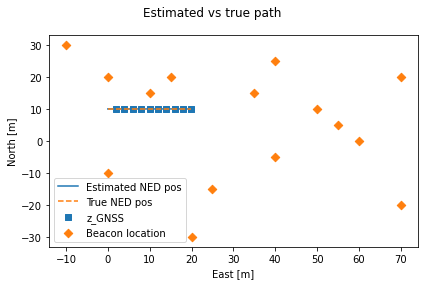

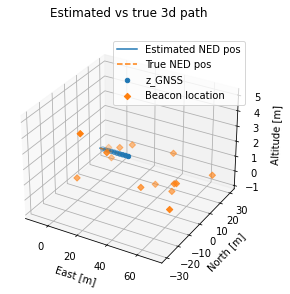

<Figure size 432x288 with 0 Axes>

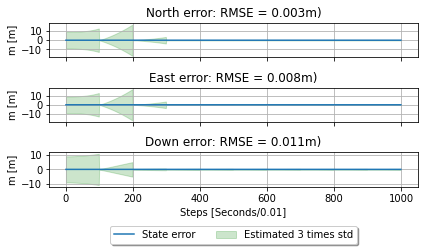

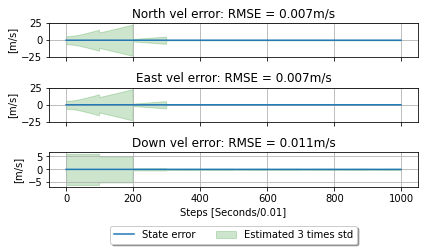

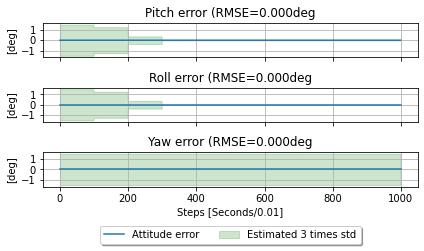

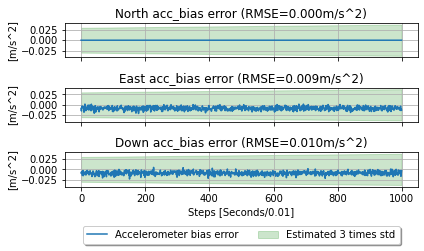

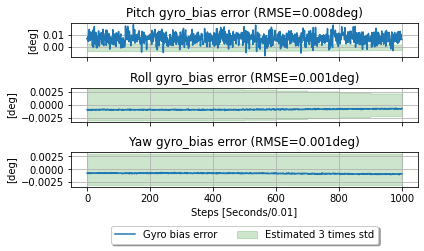

In [30]:
print("\nNumber of beacons used: ", num_beacons)
print("Number of simulations ran through", num_sims)
print("Simulation duration (seconds): ", N*dt) 

# %
if (use_batch_pseudoranges):
    for i in range(num_sims):  
        # timeit.timeit()
        print("\nUsing batch pseudoranges without factorization. Run number: ", i+1)
        
        t_batch[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        est_timer,
        pred_timer,
        elapsed_pred_timer_batch,
        elapsed_est_timer_batch
        ) = run_batch_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_batch[i] = time.time() - t_batch[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_batch[i] = np.sum(elapsed_pred_timer_batch)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_batch[i] = np.sum(elapsed_est_timer_batch)


    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path_batch',x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path3d_batch',x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'batch', 'error_pos_sigma_batch')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'batch', 'error_vel_sigma_batch')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'batch', 'error_att_sigma_batch')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_acc_bias_sigma_batch')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_rate_bias_sigma_batch')
    # Batch timings

In [31]:
    print("\nEllapsed time for batch: ", np.round(elapsed_batch,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_batch,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_batch/elapsed_batch*100,3), "%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_batch,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_batch/elapsed_batch*100,3), "%")

    average_time_batch = np.round(np.average(elapsed_batch),3)
    print("\nAverage time for batch elapsed: ", average_time_batch, "seconds")
    average_elapsed_pred_timer_batch = np.round(np.average(total_elapsed_pred_timer_batch),3)
    average_elapsed_est_timer_batch = np.round(np.average(total_elapsed_est_timer_batch),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_batch, ", where average occupies =", np.round(average_elapsed_pred_timer_batch/average_time_batch*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_batch, ", where average occupies =", np.round(average_elapsed_est_timer_batch/average_time_batch*100,3), "% " "relative to total time")


Ellapsed time for batch:  [2.687 2.191 2.004 1.808 1.926 2.402 2.361 2.451 2.32  2.51  2.393 2.498
 2.318 2.491 2.509 2.366 2.41  2.376 2.352 2.327 2.299 2.347 2.351 2.336
 2.431 2.429 2.355 2.45  2.456 2.443 2.517 2.442 2.53  2.539 2.532 2.403
 2.435 2.378 2.282 2.104 2.479 2.363 2.459 2.339 2.426 2.362 2.422 2.382
 2.403 2.449 2.431 2.361 2.505 2.431 2.538 2.435 2.365 2.313 2.368 2.403
 2.319 2.459 2.409 2.466 2.397 2.442 2.367 2.532 2.438 2.322 2.594 2.246
 2.386 2.377 2.402 2.329 2.325 2.382 2.446 2.393 2.501 2.387 2.494 2.463
 2.368 2.406 2.495 2.407 2.395 2.395 2.405 2.465 2.422 2.49  2.519 2.424
 2.58  2.517 2.287 2.392]
Summed runtime used in prediction module:  [2.637 2.14  1.945 1.742 1.871 2.354 2.31  2.399 2.269 2.459 2.343 2.45
 2.266 2.437 2.467 2.32  2.362 2.328 2.303 2.283 2.252 2.302 2.3   2.284
 2.385 2.38  2.298 2.402 2.406 2.402 2.469 2.388 2.482 2.484 2.482 2.359
 2.388 2.332 2.237 2.059 2.432 2.314 2.414 2.292 2.379 2.313 2.37  2.335
 2.355 2.397 2.383 2.313 2.45


Using sequential pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 359.93it/s]



Using sequential pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 400.03it/s]



Using sequential pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 429.44it/s]



Using sequential pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 426.40it/s]



Using sequential pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 418.28it/s]



Using sequential pseudoranges without factorization. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 443.74it/s]



Using sequential pseudoranges without factorization. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 419.55it/s]



Using sequential pseudoranges without factorization. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 390.71it/s]



Using sequential pseudoranges without factorization. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 386.03it/s]



Using sequential pseudoranges without factorization. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 424.23it/s]



Using sequential pseudoranges without factorization. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 430.25it/s]



Using sequential pseudoranges without factorization. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 386.47it/s]



Using sequential pseudoranges without factorization. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 392.74it/s]



Using sequential pseudoranges without factorization. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.05it/s]



Using sequential pseudoranges without factorization. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 505.73it/s]



Using sequential pseudoranges without factorization. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 424.83it/s]



Using sequential pseudoranges without factorization. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 438.19it/s]



Using sequential pseudoranges without factorization. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 428.97it/s]



Using sequential pseudoranges without factorization. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 413.97it/s]



Using sequential pseudoranges without factorization. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 388.25it/s]



Using sequential pseudoranges without factorization. Run number:  21
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 381.62it/s]



Using sequential pseudoranges without factorization. Run number:  22
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 416.31it/s]



Using sequential pseudoranges without factorization. Run number:  23
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.98it/s]



Using sequential pseudoranges without factorization. Run number:  24
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 384.43it/s]



Using sequential pseudoranges without factorization. Run number:  25
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 390.07it/s]



Using sequential pseudoranges without factorization. Run number:  26
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 404.05it/s]



Using sequential pseudoranges without factorization. Run number:  27
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.48it/s]



Using sequential pseudoranges without factorization. Run number:  28
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 375.95it/s]



Using sequential pseudoranges without factorization. Run number:  29
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 390.42it/s]



Using sequential pseudoranges without factorization. Run number:  30
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 397.31it/s]



Using sequential pseudoranges without factorization. Run number:  31
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.48it/s]



Using sequential pseudoranges without factorization. Run number:  32
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 389.69it/s]



Using sequential pseudoranges without factorization. Run number:  33
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 400.98it/s]



Using sequential pseudoranges without factorization. Run number:  34
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 403.16it/s]



Using sequential pseudoranges without factorization. Run number:  35
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 387.89it/s]



Using sequential pseudoranges without factorization. Run number:  36
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 382.84it/s]



Using sequential pseudoranges without factorization. Run number:  37
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 391.95it/s]



Using sequential pseudoranges without factorization. Run number:  38
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 420.20it/s]



Using sequential pseudoranges without factorization. Run number:  39
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 383.72it/s]



Using sequential pseudoranges without factorization. Run number:  40
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 400.26it/s]



Using sequential pseudoranges without factorization. Run number:  41
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 403.98it/s]



Using sequential pseudoranges without factorization. Run number:  42
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.81it/s]



Using sequential pseudoranges without factorization. Run number:  43
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 386.46it/s]



Using sequential pseudoranges without factorization. Run number:  44
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 373.64it/s]



Using sequential pseudoranges without factorization. Run number:  45
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 397.85it/s]



Using sequential pseudoranges without factorization. Run number:  46
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 394.15it/s]



Using sequential pseudoranges without factorization. Run number:  47
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 417.93it/s]



Using sequential pseudoranges without factorization. Run number:  48
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 394.93it/s]



Using sequential pseudoranges without factorization. Run number:  49
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 410.22it/s]



Using sequential pseudoranges without factorization. Run number:  50
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 401.69it/s]



Using sequential pseudoranges without factorization. Run number:  51
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.49it/s]



Using sequential pseudoranges without factorization. Run number:  52
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 375.90it/s]



Using sequential pseudoranges without factorization. Run number:  53
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 405.79it/s]



Using sequential pseudoranges without factorization. Run number:  54
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 419.39it/s]



Using sequential pseudoranges without factorization. Run number:  55
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 408.21it/s]



Using sequential pseudoranges without factorization. Run number:  56
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 423.52it/s]



Using sequential pseudoranges without factorization. Run number:  57
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 396.90it/s]



Using sequential pseudoranges without factorization. Run number:  58
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 389.58it/s]



Using sequential pseudoranges without factorization. Run number:  59
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 391.85it/s]



Using sequential pseudoranges without factorization. Run number:  60
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 394.19it/s]



Using sequential pseudoranges without factorization. Run number:  61
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 380.41it/s]



Using sequential pseudoranges without factorization. Run number:  62
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 388.05it/s]



Using sequential pseudoranges without factorization. Run number:  63
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 387.46it/s]



Using sequential pseudoranges without factorization. Run number:  64
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 395.08it/s]



Using sequential pseudoranges without factorization. Run number:  65
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 444.85it/s]



Using sequential pseudoranges without factorization. Run number:  66
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 395.49it/s]



Using sequential pseudoranges without factorization. Run number:  67
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 416.10it/s]



Using sequential pseudoranges without factorization. Run number:  68
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 398.73it/s]



Using sequential pseudoranges without factorization. Run number:  69
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 415.37it/s]



Using sequential pseudoranges without factorization. Run number:  70
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.54it/s]



Using sequential pseudoranges without factorization. Run number:  71
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 429.41it/s]



Using sequential pseudoranges without factorization. Run number:  72
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 412.67it/s]



Using sequential pseudoranges without factorization. Run number:  73
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 459.49it/s]



Using sequential pseudoranges without factorization. Run number:  74
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 451.41it/s]



Using sequential pseudoranges without factorization. Run number:  75
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 523.15it/s]



Using sequential pseudoranges without factorization. Run number:  76
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 565.73it/s]



Using sequential pseudoranges without factorization. Run number:  77
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 553.68it/s]



Using sequential pseudoranges without factorization. Run number:  78
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 562.87it/s]



Using sequential pseudoranges without factorization. Run number:  79
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 599.99it/s]



Using sequential pseudoranges without factorization. Run number:  80
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 564.80it/s]



Using sequential pseudoranges without factorization. Run number:  81
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 565.10it/s]



Using sequential pseudoranges without factorization. Run number:  82
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 590.08it/s]



Using sequential pseudoranges without factorization. Run number:  83
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 561.92it/s]



Using sequential pseudoranges without factorization. Run number:  84
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 619.29it/s]



Using sequential pseudoranges without factorization. Run number:  85
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 553.83it/s]



Using sequential pseudoranges without factorization. Run number:  86
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 561.29it/s]



Using sequential pseudoranges without factorization. Run number:  87
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:01<00:00, 578.48it/s]



Using sequential pseudoranges without factorization. Run number:  88
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 452.89it/s]



Using sequential pseudoranges without factorization. Run number:  89
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 414.21it/s]



Using sequential pseudoranges without factorization. Run number:  90
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 410.95it/s]



Using sequential pseudoranges without factorization. Run number:  91
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 388.30it/s]



Using sequential pseudoranges without factorization. Run number:  92
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 402.94it/s]



Using sequential pseudoranges without factorization. Run number:  93
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 400.90it/s]



Using sequential pseudoranges without factorization. Run number:  94
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 467.70it/s]



Using sequential pseudoranges without factorization. Run number:  95
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 401.61it/s]



Using sequential pseudoranges without factorization. Run number:  96
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 406.52it/s]



Using sequential pseudoranges without factorization. Run number:  97
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 398.75it/s]



Using sequential pseudoranges without factorization. Run number:  98
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 393.43it/s]



Using sequential pseudoranges without factorization. Run number:  99
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 393.24it/s]



Using sequential pseudoranges without factorization. Run number:  100
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:02<00:00, 437.06it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent

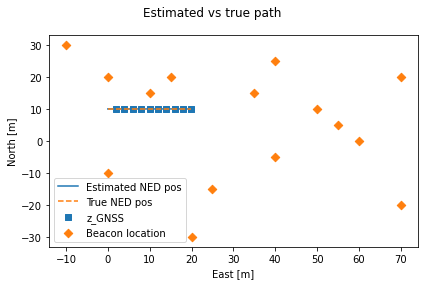

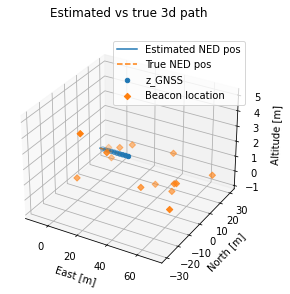

<Figure size 432x288 with 0 Axes>

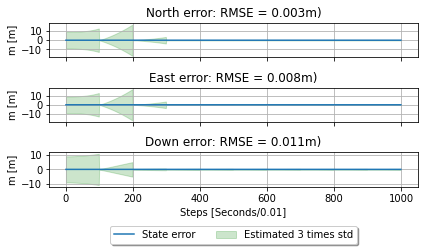

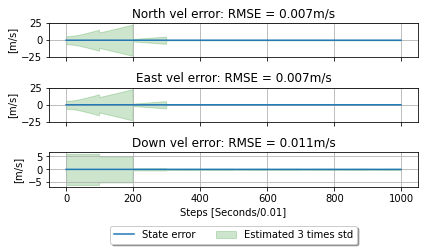

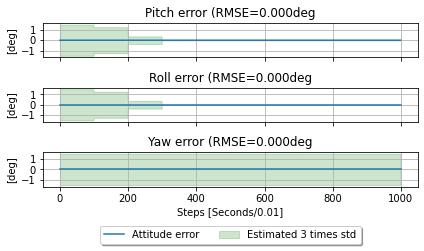

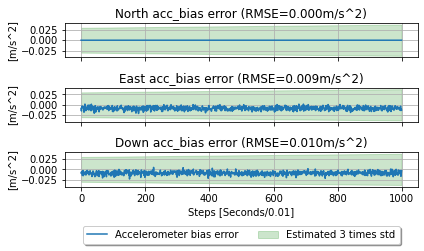

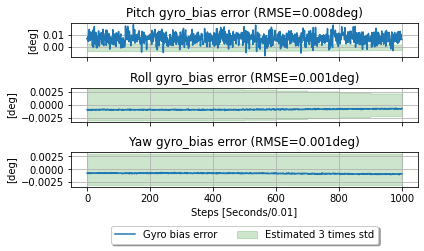

In [32]:
if (use_sequential_pseudoranges):
    for i in range(num_sims):
        print("\nUsing sequential pseudoranges without factorization. Run number: ", i+1)  
        # timeit.timeit()
        t_sequential[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_sequential,
        elapsed_est_timer_sequential
        ) = run_sequential_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
            
        elapsed_sequential[i] = time.time() - t_sequential[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_sequential[i] = np.sum(elapsed_pred_timer_sequential)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_sequential[i] = np.sum(elapsed_est_timer_sequential)

    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path_seq', x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path3d_seq', x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'sequential', 'error_pos_sigma_seq')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'sequential', 'error_vel_sigma_seq')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'sequential', 'error_att_sigma_seq')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_acc_bias_sigma_seq')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_rate_bias_sigma_seq')
    
    ## Sequential timings

In [33]:
    print("\nEllapsed time for sequential: ", np.round(elapsed_sequential,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_sequential,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_sequential/elapsed_sequential*100,3),"%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_sequential,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_sequential/elapsed_sequential*100,3),"%")
  

    average_time_sequential = np.round(np.average(elapsed_sequential),3)
    print("\nAverage time for sequential elapsed: ", average_time_sequential, "seconds")
    average_elapsed_pred_timer_sequential = np.round(np.average(total_elapsed_pred_timer_sequential),3)
    average_elapsed_est_timer_sequential = np.round(np.average(total_elapsed_est_timer_sequential),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_sequential, ", where average occupies =", np.round(average_elapsed_pred_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_sequential, ", where average occupies =", np.round(average_elapsed_est_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")


Ellapsed time for sequential:  [2.803 2.523 2.352 2.37  2.414 2.278 2.406 2.583 2.614 2.38  2.349 2.61
 2.569 2.434 2.003 2.379 2.305 2.355 2.439 2.601 2.647 2.426 2.428 2.625
 2.589 2.499 2.432 2.683 2.585 2.539 2.431 2.59  2.518 2.503 2.601 2.637
 2.574 2.404 2.63  2.522 2.5   2.436 2.612 2.7   2.537 2.562 2.417 2.555
 2.461 2.513 2.436 2.684 2.488 2.408 2.473 2.384 2.544 2.59  2.574 2.561
 2.654 2.601 2.605 2.554 2.27  2.553 2.426 2.53  2.432 2.436 2.352 2.447
 2.2   2.245 1.935 1.792 1.831 1.801 1.692 1.797 1.794 1.719 1.805 1.639
 1.83  1.807 1.751 2.232 2.439 2.456 2.6   2.505 2.518 2.162 2.514 2.486
 2.532 2.567 2.569 2.313]
Summed runtime used in prediction module:  [2.742 2.469 2.295 2.32  2.36  2.222 2.351 2.523 2.564 2.332 2.296 2.551
 2.515 2.378 1.944 2.319 2.255 2.304 2.384 2.539 2.591 2.374 2.377 2.574
 2.535 2.444 2.377 2.628 2.532 2.48  2.37  2.532 2.465 2.451 2.551 2.58
 2.524 2.352 2.574 2.46  2.443 2.377 2.554 2.644 2.479 2.508 2.364 2.501
 2.403 2.453 2.388 2.627 

Using sequential pseudoranges with UDU Propagation. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.54it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 212.40it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 233.55it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 220.08it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 223.88it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 213.39it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 200.42it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 200.80it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 213.69it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.52it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 207.58it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 212.28it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 206.36it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 201.95it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 218.76it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 208.46it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 217.72it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 216.03it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 216.36it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 215.60it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  21
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 216.50it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  22
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 209.54it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  23
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.78it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  24
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 211.67it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  25
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 208.98it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  26
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 212.96it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  27
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 221.86it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  28
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 212.37it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  29
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 209.89it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  30
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 213.42it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  31
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 214.82it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  32
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 206.06it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  33
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 208.76it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  34
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 215.22it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  35
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 216.62it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  36
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 205.67it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  37
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 198.94it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  38
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 206.04it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  39
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 201.98it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  40
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 205.44it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  41
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 196.65it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  42
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 209.33it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  43
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 206.79it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  44
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 197.07it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  45
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 205.53it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  46
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 208.68it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  47
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.31it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  48
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 206.06it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  49
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 211.06it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  50
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.11it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  51
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 193.81it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  52
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 211.49it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  53
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 203.48it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  54
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 204.92it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  55
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 208.71it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  56
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 202.77it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  57
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 199.52it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  58
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 196.51it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  59
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 204.82it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  60
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 202.89it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  61
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 206.72it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  62
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 202.47it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  63
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.63it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  64
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 199.22it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  65
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 203.08it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  66
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.56it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  67
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 200.89it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  68
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 217.52it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  69
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 203.52it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  70
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 204.82it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  71
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 219.90it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  72
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 206.90it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  73
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 202.82it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  74
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 207.77it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  75
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 207.96it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  76
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:05<00:00, 199.43it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  77
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 218.42it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  78
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 246.16it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  79
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 228.58it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  80
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 223.43it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  81
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 219.79it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  82
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 218.13it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  83
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 218.21it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  84
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 218.09it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  85
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 222.98it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  86
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 216.30it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  87
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 223.05it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  88
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 226.83it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  89
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 220.29it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  90
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 221.07it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  91
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 222.11it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  92
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 222.08it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  93
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 217.31it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  94
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 220.58it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  95
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 217.45it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  96
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 210.21it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  97
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 224.21it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  98
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 216.20it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  99
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 214.06it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  100
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 1000/1000 [00:04<00:00, 217.07it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent

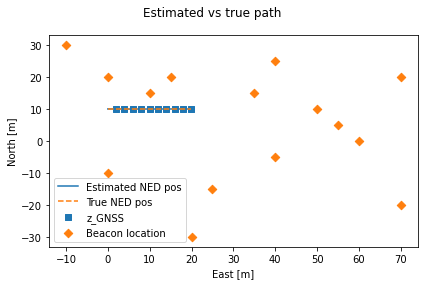

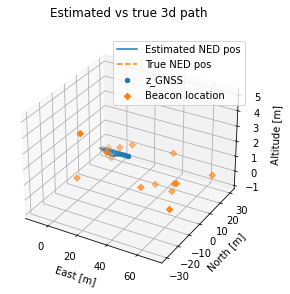

<Figure size 432x288 with 0 Axes>

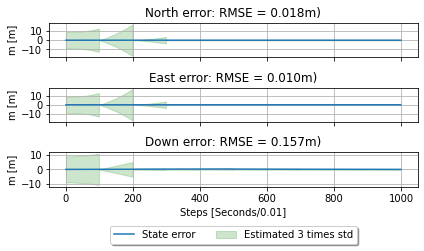

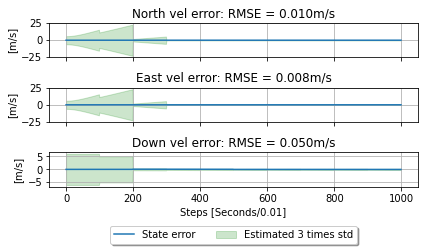

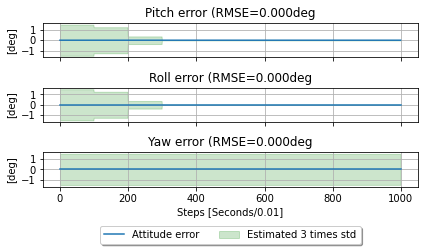

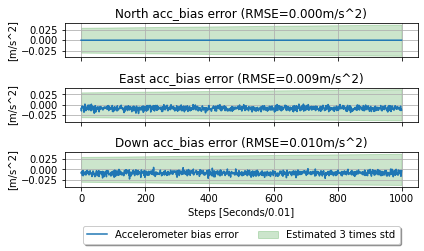

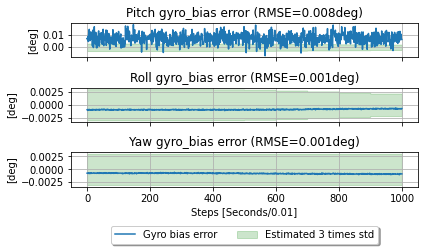

In [34]:
if (use_UDU):
    for i in range(num_sims):  
        # timeit.timeit()
        print("Using sequential pseudoranges with UDU Propagation. Run number: ", i+1)
        
        t_UDU[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_UDU,
        elapsed_est_timer_UDU
        ) = run_UDU_eskf (
                            N, loaded_data,
                            use_UDU,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_UDU[i] = time.time() - t_UDU[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_UDU[i] = np.sum(elapsed_pred_timer_UDU)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_UDU[i] = np.sum(elapsed_est_timer_UDU)
        
    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path_udu', x_true,)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path3d_udu', x_true,)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'udu', 'error_pos_sigma_udu')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'udu', 'error_vel_sigma_udu')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'udu', 'error_att_sigma_udu')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_acc_bias_sigma_udu')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_rate_bias_sigma_udu')
    ## UDU timings

In [35]:
    print("\nEllapsed time for UDU: ",  np.round(elapsed_UDU,3))
    print("Summed runtime used in UDU prediction module: ",  np.round(total_elapsed_pred_timer_UDU,3), "seconds")
    print("Portion of runtime prediction module in UDU occupies: ",  np.round(total_elapsed_pred_timer_UDU/elapsed_UDU,3),"%")
    print("Summed runtime used in UDU estimation module: ",  np.round(total_elapsed_est_timer_UDU,3), "seconds")
    print("Portion of runtime estimation module in UDU ccupies: ",  np.round(total_elapsed_est_timer_UDU/elapsed_UDU,3),"%")

    average_time_UDU = np.round(np.average(elapsed_UDU),3)
    print("\nAverage time for UDU elapsed: ", np.round(average_time_UDU,3), "seconds")
    average_elapsed_pred_timer_UDU = np.round(np.average(total_elapsed_pred_timer_UDU),3)
    average_elapsed_est_timer_UDU = np.round(np.average(total_elapsed_est_timer_UDU),3)
    print("Average runtime for prediction module in UDU: ", average_elapsed_pred_timer_UDU, ", where average occupies =",  np.round(average_elapsed_pred_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")
    print("Average runtime for estimation module in UDU: ", average_elapsed_est_timer_UDU, ", where average occupies =",  np.round(average_elapsed_est_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")


Ellapsed time for UDU:  [4.772 4.731 4.304 4.566 4.49  4.709 5.013 5.004 4.703 4.775 4.84  4.735
 4.868 4.974 4.596 4.819 4.616 4.652 4.645 4.661 4.642 4.795 4.768 4.747
 4.81  4.719 4.531 4.731 4.787 4.709 4.678 4.874 4.813 4.67  4.64  4.885
 5.049 4.874 4.974 4.892 5.11  4.799 4.858 5.097 4.887 4.814 4.777 4.875
 4.762 4.781 5.183 4.75  4.938 4.903 4.814 4.955 5.034 5.113 4.905 4.952
 4.862 4.964 4.772 5.042 4.947 4.772 5.    4.62  4.936 4.906 4.57  4.856
 4.953 4.836 4.831 5.037 4.601 4.086 4.397 4.497 4.58  4.606 4.604 4.608
 4.507 4.646 4.506 4.43  4.561 4.547 4.524 4.525 4.624 4.557 4.621 4.779
 4.481 4.647 4.694 4.63 ]
Summed runtime used in UDU prediction module:  [4.508 4.462 4.04  4.294 4.224 4.44  4.744 4.734 4.434 4.506 4.572 4.464
 4.601 4.701 4.326 4.537 4.348 4.38  4.375 4.39  4.374 4.512 4.493 4.486
 4.537 4.447 4.252 4.454 4.523 4.437 4.412 4.601 4.54  4.404 4.366 4.617
 4.779 4.608 4.705 4.615 4.835 4.535 4.577 4.82  4.618 4.54  4.507 4.597
 4.491 4.504 4.905 4.48  4

In [36]:
## Relative relations
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of batch vs sequential: ",  np.round((average_time_batch - average_time_sequential)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_sequential)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_sequential)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs sequential:  0.125 %
Average Relative speedup of pred module in batch vs sequential:  0.426 %
Average Relative speedup of est module in batch vs sequential:  0.0 %


In [37]:
if (use_batch_pseudoranges & use_UDU):
    print("\nAverage Relative speedup of batch vs UDU-sequential: ",  np.round((average_time_batch - average_time_UDU)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs UDU-sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs UDU-sequential:  -98.29 %
Average Relative speedup of pred module in batch vs UDU-sequential:  -90.936 %
Average Relative speedup of est module in batch vs UDU-sequential:  -1428.571 %


In [38]:
if (use_UDU & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of sequential vs UDU-sequential: ",  np.round((average_time_sequential - average_time_UDU)/average_time_sequential*100,3),"%")
    print("Average Relative speedup of pred module in sequential vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_sequential - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_sequential*100,3), "%")
    print("Average Relative speedup of est module in  sequential vs UDU-sequential: ",  np.round((average_elapsed_est_timer_sequential - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_sequential*100,3), "%")


Average Relative speedup of sequential vs UDU-sequential:  -98.539 %
Average Relative speedup of pred module in sequential vs UDU-sequential:  -91.752 %
Average Relative speedup of est module in  sequential vs UDU-sequential:  -1428.571 %


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

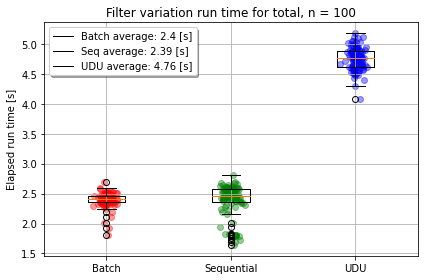

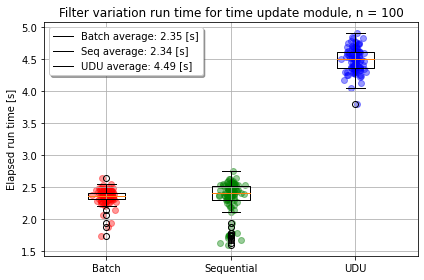

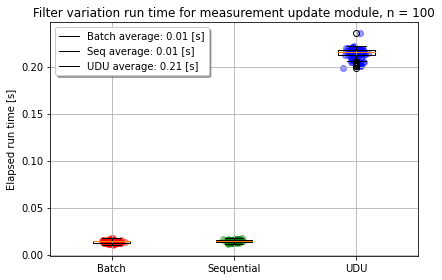

In [39]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

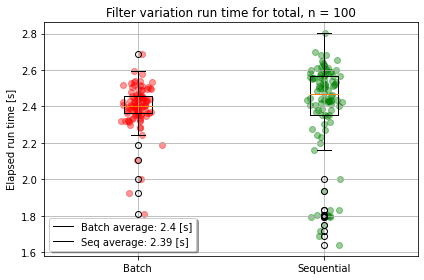

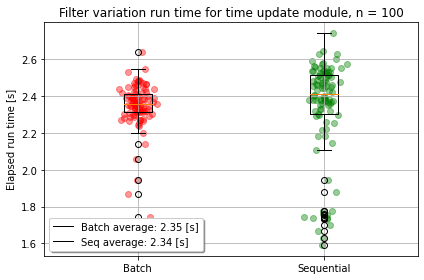

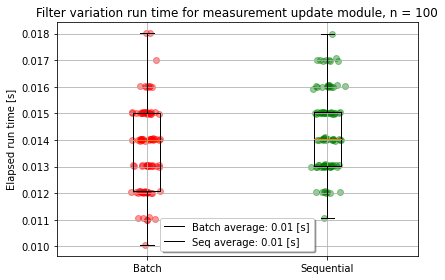

In [40]:
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    if (N ==10/dt):
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing10','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing10','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==100/dt):
        plot_timing_scatter2('timing100','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing100','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing100','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==600/dt):
        plot_timing_scatter2('timing600','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing600','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing600','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==1000/dt):
        plot_timing_scatter2('timing1000','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing1000','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing1000','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                

In [41]:
from plotter import plot_NEES, plot_NIS, plot_angle, plot_error_pos_sigma, plot_error_vel_sigma, plot_path, state_error_plots
from typing import Tuple, Sequence, Any
from matplotlib import pyplot as plt


# from plotfunctionstesting import plot_acc, plot_acc2, plot_gyro, plot_angle

import numpy as np
import scipy.linalg as la
import scipy
import scipy.io
import scipy.stats
from dataclasses import dataclass, field
import timeit
import time

import tqdm
import os
import sys

from tqdm import trange
from tqdm import tqdm_notebook

from quaternion import * 
from cat_slice import CatSlice
# from eskf import ESKF
# from eskf import ESKF

from utils import UDU_factorization

from eskf_batch import ESKF_batch
from eskf_sequential import ESKF_sequential
from eskf_UDU import ESKF_udu
from eskf_runner import run_batch_eskf, run_sequential_eskf, run_UDU_eskf
from plotter import * #plot_error_v_sigma, plot_pos, plot_vel, plot_angle, plot_estimate, plot_3Dpath, plot_path, state_error_plots, plot_NEES, plot_NIS
# from timer import * 

In [42]:
plt.close('all')

from plot_setup import setup_plot
setup_plot()
np.seterr(all='raise')
scipy.special.seterr(all='raise')

matplotlib backend: module://matplotlib_inline.backend_inline
matplotlib config file: C:\Python39\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\Users\Andreas\.matplotlib
Plotting is set to inline at the moment: unknown inline backend
continuing with this plotting backend


pyplot using style set ['science', 'grid', 'no-latex']


{'singular': 'raise',
 'underflow': 'raise',
 'overflow': 'raise',
 'slow': 'raise',
 'loss': 'raise',
 'no_result': 'raise',
 'domain': 'raise',
 'arg': 'raise',
 'other': 'raise'}

In [43]:
"""
Q_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std
R: p_std -> R_GNSS = p_std**2*eye(3)
"""

'\nQ_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std\nR: p_std -> R_GNSS = p_std**2*eye(3)\n'

In [44]:
"""
Loads true state, time steps and other simulation variables. Run gen_mat to generate
new data
"""

folder = os.path.dirname(__file__)
# filename_to_load = f"{folder}/../data/simulation_params.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver2.mat"
filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver3.mat"
cache_folder = os.path.join(folder,'..', 'cache')
loaded_data = scipy.io.loadmat(filename_to_load)

timeIMU = loaded_data["timeIMU"].ravel()
#acc_t = loaded_data["acc_t"].T
if 'x_true' in loaded_data:
    x_true = loaded_data["x_true"].T
else:
    x_true = None
# z_GNSS = loaded_data["z_GNSS"].T
    
beacon_location = loaded_data["beacon_location"]

tGNSS = loaded_data["timeGNSS"].T
z_GNSS = loaded_data["z_GNSS"].T

z_acc_vector = loaded_data["z_acc"].T
acc_t = loaded_data["acc_t"].T
omega_t = loaded_data["omega_t"].T
z_gyro_vector = loaded_data["z_gyro"].T

dt = np.mean(np.diff(timeIMU))

In [45]:
POS_IDX = CatSlice(start=0, stop=3)
VEL_IDX = CatSlice(start=3, stop=6)
ATT_IDX = CatSlice(start=6, stop=10)
ACC_BIAS_IDX = CatSlice(start=10, stop=13)
GYRO_BIAS_IDX = CatSlice(start=13, stop=16)

ERR_ATT_IDX = CatSlice(start=6, stop=9)
ERR_ACC_BIAS_IDX = CatSlice(start=9, stop=12)
ERR_GYRO_BIAS_IDX = CatSlice(start=12, stop=15)

In [46]:
# Initializing prediction
x_pred_init = np.zeros(16)

# 8 figure init
x_pred_init[POS_IDX] = np.array([10,0,1])
x_pred_init[VEL_IDX] = np.array([0, 2, 0])
x_pred_init[6:10] = np.array([1,0,0,0]) #(0,0,0) iny euler
# x_pred_init[10:13] = np.array([-8.75e-2,-8.74e-2,6.9e-2])
# x_pred_init[13:16] = np.array([-9.54e-4,-7.32e-04,3.37e-04])

# x_pred_init[POS_IDX] = np.array([0, 0, -5])  # starting 5 metres above ground
# x_pred_init[VEL_IDX] = np.array([20, 0, 0])  # starting at 20 m/s due north
# no initial rotation: nose to North, right to East, and belly down
# x_pred_init[6] = 1

In [47]:
# acc_std = 7.59562072e-02
# rate_std =  5.12679127e-02

# cont_acc_bias_driving_noise_std =  1.16562328e-04
# cont_rate_bias_driving_noise_std =  1.94631260e-05

In [48]:
# TUNABLE0.01035
# cont_gyro_noise_std =  0.01035
cont_gyro_noise_std =   4.36e-5  # (rad/s)/sqrt(Hz)
# TUNABLE 0.015191 
# cont_acc_noise_std = np.array([0.01, 0.01, 0.042191])
# cont_acc_noise_std = 0.01549 #1.167e-2  # (m/s**2)/sqrt(Hz)
cont_acc_noise_std =  1.167e-2  # (m/s**2)/sqrt(Hz)

# cont_gyro_noise_std = 0.001      #4.36e-5  # (rad/s)/sqrt(Hz)
# cont_acc_noise_std = 0.001  #1.167e-3  # (m/s**2)/sqrt(Hz)

# Discrete sample noise at simulation rate used
# This is the formula from example 4.9. Should this be the driving noise instead?
rate_std = np.round(0.5 * cont_gyro_noise_std * np.sqrt(1 / dt),7) #Just to avoid float shit
acc_std = np.round(0.5 * cont_acc_noise_std * np.sqrt(1 / dt),7)

# Bias values
# TUNABLE 0.0005839  0.00005839 
# 5e-5 From another simulation
rate_bias_driving_noise_std =  5e-5 

cont_rate_bias_driving_noise_std = (
    np.round((1 / 3) * rate_bias_driving_noise_std / np.sqrt(1 / dt), 7)
)
#4e-3 From another simulation
#0.0001947, 0.0020947 0.0050947
acc_bias_driving_noise_std = 4e-3
cont_acc_bias_driving_noise_std = 6 * acc_bias_driving_noise_std / np.sqrt(1 / dt)

In [49]:
p_acc =   1.000e-6
p_gyro = 1.00000000e-6

In [50]:
# p_std = np.array([1.58170828, 1.58170828, 0.97243219])   # Measurement noise

#The measurements from the GNSS are perfect at the moment
# p_std = np.array([0, 0, 0])
p_std = np.array([.01, .01, .03])
# p_std = np.array([.1, .1, .3])
# p_std = np.array([.3, .3, .5])

In [51]:
P_pred_init = np.zeros((15,15))
P_pred_init[POS_IDX ** 2] = np.eye(3) * 3**2  
P_pred_init[VEL_IDX ** 2] = np.eye(3) * 2**2  #0.2
P_pred_init[ERR_ATT_IDX ** 2] = np.eye(3) * 0.5**2  # TODO
P_pred_init[ERR_ACC_BIAS_IDX ** 2] = np.eye(3) * 0.01**2 
P_pred_init[ERR_GYRO_BIAS_IDX ** 2] = np.eye(3) * 0.001**2 # 0.001**2 
 
eskf_parameters = [acc_std,
                    rate_std,
                    cont_acc_bias_driving_noise_std,
                    cont_rate_bias_driving_noise_std,
                    p_acc,
                    p_gyro]   

In [52]:
#Number of seconds of simulation to run. len(timeIMU) decides max

# N: int = int(10/dt) 
N: int = int(100/dt)
# N: int = int(600/dt) 
# N: int = int(1000/dt)
# N: int = int(90000)
# N: int = len(timeIMU)
offset = 0
doGNSS: bool = True
# rtol = 1e-05
# atol = 1e-08

In [53]:
# plt.close("all")
t = np.linspace(0,dt * (N-1), N)
# plot_path(t, N, pos_t, pos_t)

In [54]:
"""
Running the simulation
"""
beacon_location: np.ndarray = loaded_data["beacon_location"]

use_batch_pseudoranges: bool = True
# use_batch_pseudoranges: bool = False
use_sequential_pseudoranges: bool = True
# use_sequential_pseudoranges: bool = False
use_UDU: bool = True
# use_UDU: bool = False

num_beacons = len(beacon_location)
num_sims = 20

#Timers for batch-filter
t_batch = np.zeros(num_sims)
elapsed_batch = np.zeros(num_sims)

#Timers for sequential filter
t_sequential = np.zeros(num_sims)
elapsed_sequential = np.zeros(num_sims)

#Timers for UDU filter
t_UDU = np.zeros(num_sims)
elapsed_UDU = np.zeros(num_sims)

#Timers for submodules
total_elapsed_pred_timer_batch = np.zeros(num_sims)
total_elapsed_est_timer_batch = np.zeros(num_sims)
average_elapsed_pred_timer_batch = np.zeros(num_sims)
average_elapsed_est_timer_batch = np.zeros(num_sims)

total_elapsed_pred_timer_sequential = np.zeros(num_sims)
total_elapsed_est_timer_sequential = np.zeros(num_sims)
average_elapsed_pred_timer_sequential = np.zeros(num_sims)
average_elapsed_est_timer_sequential = np.zeros(num_sims)

total_elapsed_pred_timer_UDU = np.zeros(num_sims)
total_elapsed_est_timer_UDU = np.zeros(num_sims)
average_elapsed_pred_timer_UDU = np.zeros(num_sims)
average_elapsed_est_timer_UDU = np.zeros(num_sims)


Number of beacons used:  15
Number of simulations ran through 20
Simulation duration (seconds):  100.0

Using batch pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:23<00:00, 434.11it/s]



Using batch pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 445.93it/s]



Using batch pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 442.06it/s]



Using batch pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 440.72it/s]



Using batch pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 448.98it/s]



Using batch pseudoranges without factorization. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:23<00:00, 429.05it/s]



Using batch pseudoranges without factorization. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 441.39it/s]



Using batch pseudoranges without factorization. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 438.75it/s]



Using batch pseudoranges without factorization. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 435.62it/s]



Using batch pseudoranges without factorization. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 437.12it/s]



Using batch pseudoranges without factorization. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 444.51it/s]



Using batch pseudoranges without factorization. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:21<00:00, 458.90it/s]



Using batch pseudoranges without factorization. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:23<00:00, 434.47it/s]



Using batch pseudoranges without factorization. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:21<00:00, 455.52it/s]



Using batch pseudoranges without factorization. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 435.09it/s]



Using batch pseudoranges without factorization. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 437.88it/s]



Using batch pseudoranges without factorization. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:23<00:00, 434.24it/s]



Using batch pseudoranges without factorization. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 443.14it/s]



Using batch pseudoranges without factorization. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 441.82it/s]



Using batch pseudoranges without factorization. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:22<00:00, 440.95it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpare

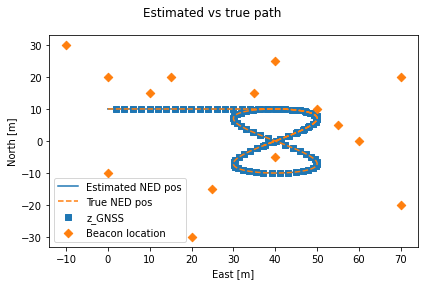

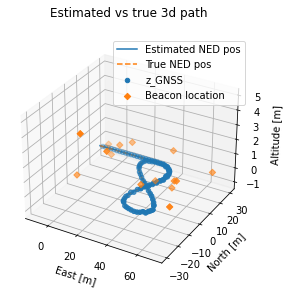

<Figure size 432x288 with 0 Axes>

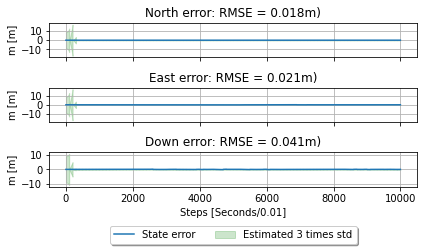

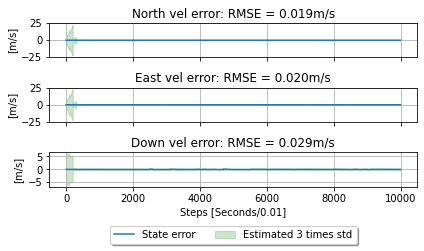

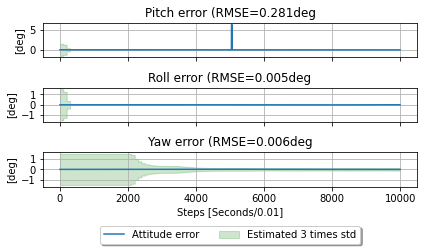

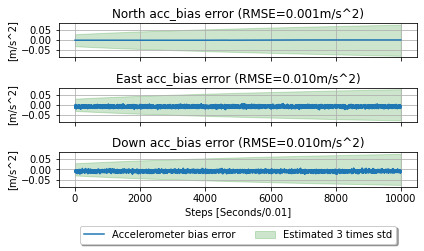

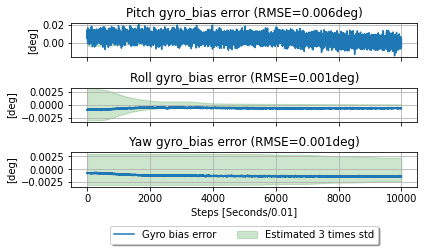

In [55]:
print("\nNumber of beacons used: ", num_beacons)
print("Number of simulations ran through", num_sims)
print("Simulation duration (seconds): ", N*dt) 

# %
if (use_batch_pseudoranges):
    for i in range(num_sims):  
        # timeit.timeit()
        print("\nUsing batch pseudoranges without factorization. Run number: ", i+1)
        
        t_batch[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        est_timer,
        pred_timer,
        elapsed_pred_timer_batch,
        elapsed_est_timer_batch
        ) = run_batch_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_batch[i] = time.time() - t_batch[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_batch[i] = np.sum(elapsed_pred_timer_batch)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_batch[i] = np.sum(elapsed_est_timer_batch)


    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path_batch',x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path3d_batch',x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'batch', 'error_pos_sigma_batch')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'batch', 'error_vel_sigma_batch')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'batch', 'error_att_sigma_batch')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_acc_bias_sigma_batch')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_rate_bias_sigma_batch')
    # Batch timings

In [56]:
    print("\nEllapsed time for batch: ", np.round(elapsed_batch,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_batch,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_batch/elapsed_batch*100,3), "%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_batch,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_batch/elapsed_batch*100,3), "%")

    average_time_batch = np.round(np.average(elapsed_batch),3)
    print("\nAverage time for batch elapsed: ", average_time_batch, "seconds")
    average_elapsed_pred_timer_batch = np.round(np.average(total_elapsed_pred_timer_batch),3)
    average_elapsed_est_timer_batch = np.round(np.average(total_elapsed_est_timer_batch),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_batch, ", where average occupies =", np.round(average_elapsed_pred_timer_batch/average_time_batch*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_batch, ", where average occupies =", np.round(average_elapsed_est_timer_batch/average_time_batch*100,3), "% " "relative to total time")


Ellapsed time for batch:  [23.06  22.452 22.647 22.716 22.299 23.332 22.682 22.818 22.98  22.902
 22.523 21.817 23.042 21.98  23.008 22.862 23.053 22.594 22.661 22.702]
Summed runtime used in prediction module:  [22.751 22.166 22.355 22.417 21.99  23.039 22.377 22.506 22.681 22.59
 22.216 21.497 22.731 21.682 22.721 22.552 22.76  22.295 22.349 22.403] seconds
Portion of runtime prediction module occupies:  [98.663 98.728 98.709 98.684 98.617 98.741 98.656 98.63  98.702 98.637
 98.64  98.532 98.649 98.646 98.753 98.641 98.731 98.677 98.623 98.682] %
Summed runtime used in estimation module:  [0.152 0.133 0.137 0.135 0.145 0.133 0.141 0.139 0.131 0.138 0.144 0.144
 0.139 0.142 0.142 0.141 0.142 0.135 0.14  0.144] seconds
Portion of runtime estimation module occupies:  [0.66  0.593 0.606 0.595 0.652 0.571 0.623 0.611 0.571 0.603 0.641 0.661
 0.604 0.647 0.619 0.617 0.617 0.599 0.619 0.635] %

Average time for batch elapsed:  22.706 seconds
Average runtime for prediction module:  22.404 ,


Using sequential pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:24<00:00, 411.61it/s]



Using sequential pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 389.02it/s]



Using sequential pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:24<00:00, 400.09it/s]



Using sequential pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 389.38it/s]



Using sequential pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 398.51it/s]



Using sequential pseudoranges without factorization. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 392.44it/s]



Using sequential pseudoranges without factorization. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 397.12it/s]



Using sequential pseudoranges without factorization. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 393.40it/s]



Using sequential pseudoranges without factorization. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 396.77it/s]



Using sequential pseudoranges without factorization. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 398.62it/s]



Using sequential pseudoranges without factorization. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 396.72it/s]



Using sequential pseudoranges without factorization. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 397.84it/s]



Using sequential pseudoranges without factorization. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 396.25it/s]



Using sequential pseudoranges without factorization. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 399.55it/s]



Using sequential pseudoranges without factorization. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 395.85it/s]



Using sequential pseudoranges without factorization. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 389.38it/s]



Using sequential pseudoranges without factorization. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 391.91it/s]



Using sequential pseudoranges without factorization. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 399.62it/s]



Using sequential pseudoranges without factorization. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:24<00:00, 401.20it/s]



Using sequential pseudoranges without factorization. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:25<00:00, 391.32it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpare

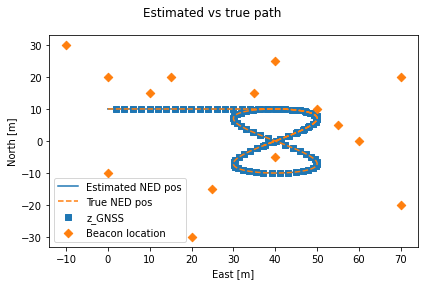

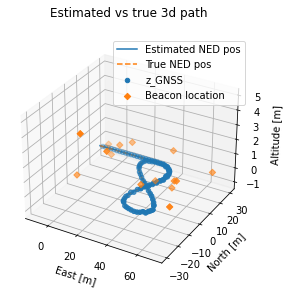

<Figure size 432x288 with 0 Axes>

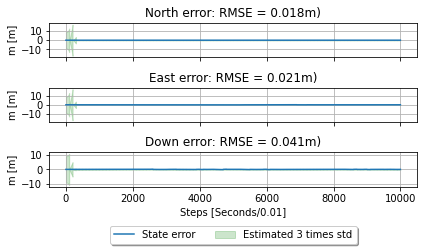

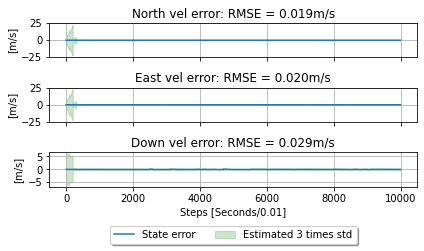

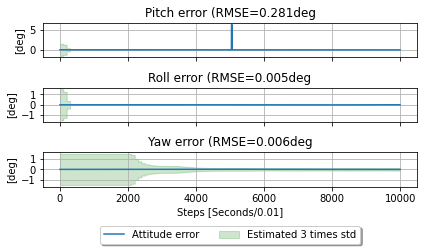

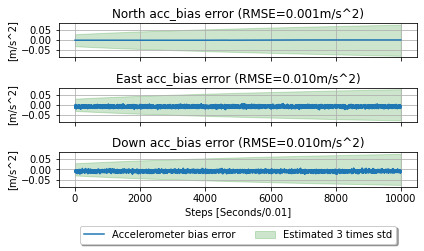

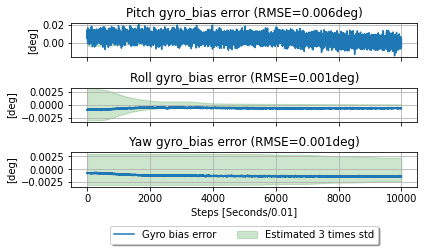

In [57]:
if (use_sequential_pseudoranges):
    for i in range(num_sims):
        print("\nUsing sequential pseudoranges without factorization. Run number: ", i+1)  
        # timeit.timeit()
        t_sequential[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_sequential,
        elapsed_est_timer_sequential
        ) = run_sequential_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
            
        elapsed_sequential[i] = time.time() - t_sequential[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_sequential[i] = np.sum(elapsed_pred_timer_sequential)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_sequential[i] = np.sum(elapsed_est_timer_sequential)

    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path_seq', x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path3d_seq', x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'sequential', 'error_pos_sigma_seq')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'sequential', 'error_vel_sigma_seq')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'sequential', 'error_att_sigma_seq')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_acc_bias_sigma_seq')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_rate_bias_sigma_seq')
    
    ## Sequential timings

In [58]:
    print("\nEllapsed time for sequential: ", np.round(elapsed_sequential,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_sequential,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_sequential/elapsed_sequential*100,3),"%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_sequential,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_sequential/elapsed_sequential*100,3),"%")
  

    average_time_sequential = np.round(np.average(elapsed_sequential),3)
    print("\nAverage time for sequential elapsed: ", average_time_sequential, "seconds")
    average_elapsed_pred_timer_sequential = np.round(np.average(total_elapsed_pred_timer_sequential),3)
    average_elapsed_est_timer_sequential = np.round(np.average(total_elapsed_est_timer_sequential),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_sequential, ", where average occupies =", np.round(average_elapsed_pred_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_sequential, ", where average occupies =", np.round(average_elapsed_est_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")


Ellapsed time for sequential:  [24.323 25.732 25.02  25.707 25.117 25.507 25.206 25.445 25.231 25.113
 25.232 25.165 25.262 25.054 25.287 25.707 25.54  25.049 24.95  25.58 ]
Summed runtime used in prediction module:  [23.971 25.401 24.666 25.377 24.776 25.179 24.861 25.115 24.903 24.769
 24.895 24.835 24.928 24.722 24.968 25.354 25.191 24.712 24.597 25.241] seconds
Portion of runtime prediction module occupies:  [98.552 98.715 98.585 98.717 98.64  98.716 98.629 98.7   98.702 98.628
 98.663 98.686 98.68  98.676 98.74  98.626 98.632 98.652 98.584 98.674] %
Summed runtime used in estimation module:  [0.143 0.137 0.146 0.135 0.15  0.145 0.158 0.148 0.144 0.142 0.144 0.139
 0.144 0.138 0.143 0.146 0.148 0.14  0.137 0.141] seconds
Portion of runtime estimation module occupies:  [0.589 0.533 0.584 0.526 0.598 0.57  0.627 0.583 0.572 0.567 0.571 0.554
 0.57  0.552 0.566 0.569 0.58  0.56  0.55  0.552] %

Average time for sequential elapsed:  25.261 seconds
Average runtime for prediction module

Using sequential pseudoranges with UDU Propagation. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:46<00:00, 217.18it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:46<00:00, 217.29it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.49it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:46<00:00, 217.11it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 217.46it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.28it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.74it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.40it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 217.93it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 217.79it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.50it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:46<00:00, 215.85it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 219.01it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:46<00:00, 216.01it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.94it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:46<00:00, 216.21it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.33it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.30it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 219.61it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 10000/10000 [00:45<00:00, 218.82it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpare

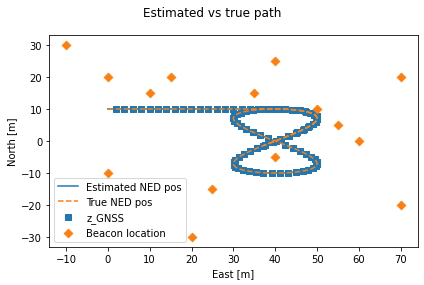

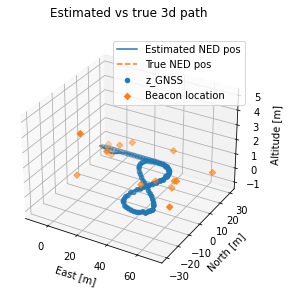

<Figure size 432x288 with 0 Axes>

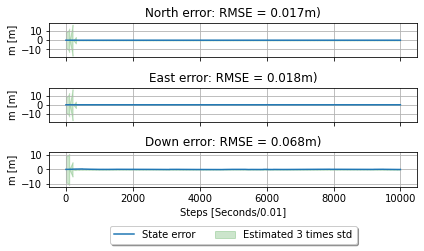

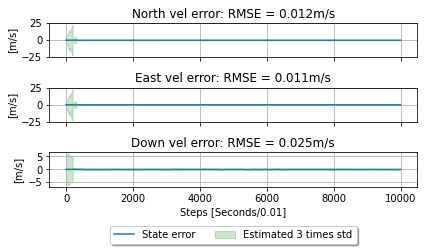

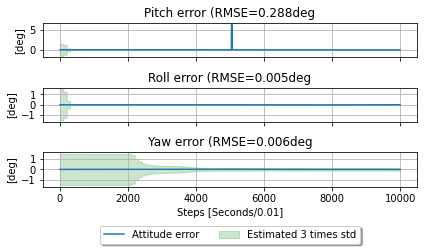

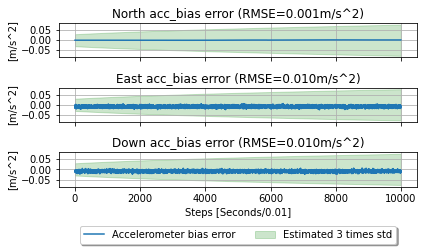

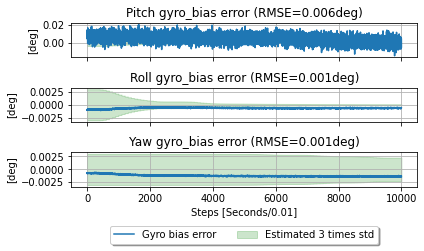

In [59]:
if (use_UDU):
    for i in range(num_sims):  
        # timeit.timeit()
        print("Using sequential pseudoranges with UDU Propagation. Run number: ", i+1)
        
        t_UDU[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_UDU,
        elapsed_est_timer_UDU
        ) = run_UDU_eskf (
                            N, loaded_data,
                            use_UDU,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_UDU[i] = time.time() - t_UDU[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_UDU[i] = np.sum(elapsed_pred_timer_UDU)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_UDU[i] = np.sum(elapsed_est_timer_UDU)
        
    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path_udu', x_true,)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path3d_udu', x_true,)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'udu', 'error_pos_sigma_udu')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'udu', 'error_vel_sigma_udu')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'udu', 'error_att_sigma_udu')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_acc_bias_sigma_udu')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_rate_bias_sigma_udu')
    ## UDU timings

In [60]:
    print("\nEllapsed time for UDU: ",  np.round(elapsed_UDU,3))
    print("Summed runtime used in UDU prediction module: ",  np.round(total_elapsed_pred_timer_UDU,3), "seconds")
    print("Portion of runtime prediction module in UDU occupies: ",  np.round(total_elapsed_pred_timer_UDU/elapsed_UDU,3),"%")
    print("Summed runtime used in UDU estimation module: ",  np.round(total_elapsed_est_timer_UDU,3), "seconds")
    print("Portion of runtime estimation module in UDU ccupies: ",  np.round(total_elapsed_est_timer_UDU/elapsed_UDU,3),"%")

    average_time_UDU = np.round(np.average(elapsed_UDU),3)
    print("\nAverage time for UDU elapsed: ", np.round(average_time_UDU,3), "seconds")
    average_elapsed_pred_timer_UDU = np.round(np.average(total_elapsed_pred_timer_UDU),3)
    average_elapsed_est_timer_UDU = np.round(np.average(total_elapsed_est_timer_UDU),3)
    print("Average runtime for prediction module in UDU: ", average_elapsed_pred_timer_UDU, ", where average occupies =",  np.round(average_elapsed_pred_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")
    print("Average runtime for estimation module in UDU: ", average_elapsed_est_timer_UDU, ", where average occupies =",  np.round(average_elapsed_est_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")


Ellapsed time for UDU:  [46.069 46.047 45.793 46.084 46.01  45.837 45.743 45.811 45.909 45.94
 45.792 46.354 45.683 46.319 45.7   46.278 45.827 45.833 45.56  45.723]
Summed runtime used in UDU prediction module:  [43.705 43.647 43.429 43.714 43.634 43.464 43.377 43.421 43.536 43.572
 43.399 43.971 43.298 43.941 43.335 43.913 43.437 43.459 43.225 43.339] seconds
Portion of runtime prediction module in UDU occupies:  [0.949 0.948 0.948 0.949 0.948 0.948 0.948 0.948 0.948 0.948 0.948 0.949
 0.948 0.949 0.948 0.949 0.948 0.948 0.949 0.948] %
Summed runtime used in UDU estimation module:  [2.083 2.084 2.069 2.068 2.059 2.066 2.062 2.078 2.064 2.067 2.066 2.078
 2.071 2.064 2.063 2.058 2.066 2.073 2.057 2.07 ] seconds
Portion of runtime estimation module in UDU ccupies:  [0.045 0.045 0.045 0.045 0.045 0.045 0.045 0.045 0.045 0.045 0.045 0.045
 0.045 0.045 0.045 0.044 0.045 0.045 0.045 0.045] %

Average time for UDU elapsed:  45.916 seconds
Average runtime for prediction module in UDU:  43.5

In [61]:
## Relative relations
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of batch vs sequential: ",  np.round((average_time_batch - average_time_sequential)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_sequential)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_sequential)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs sequential:  -11.253 %
Average Relative speedup of pred module in batch vs sequential:  -11.244 %
Average Relative speedup of est module in batch vs sequential:  -2.857 %


In [62]:
if (use_batch_pseudoranges & use_UDU):
    print("\nAverage Relative speedup of batch vs UDU-sequential: ",  np.round((average_time_batch - average_time_UDU)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs UDU-sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs UDU-sequential:  -102.22 %
Average Relative speedup of pred module in batch vs UDU-sequential:  -94.345 %
Average Relative speedup of est module in batch vs UDU-sequential:  -1377.857 %


In [63]:
if (use_UDU & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of sequential vs UDU-sequential: ",  np.round((average_time_sequential - average_time_UDU)/average_time_sequential*100,3),"%")
    print("Average Relative speedup of pred module in sequential vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_sequential - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_sequential*100,3), "%")
    print("Average Relative speedup of est module in  sequential vs UDU-sequential: ",  np.round((average_elapsed_est_timer_sequential - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_sequential*100,3), "%")


Average Relative speedup of sequential vs UDU-sequential:  -81.766 %
Average Relative speedup of pred module in sequential vs UDU-sequential:  -74.702 %
Average Relative speedup of est module in  sequential vs UDU-sequential:  -1336.806 %


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

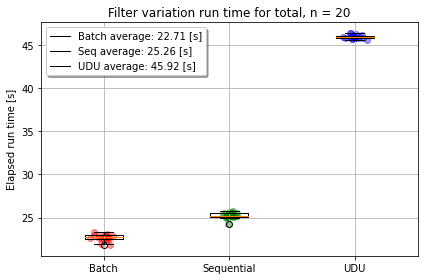

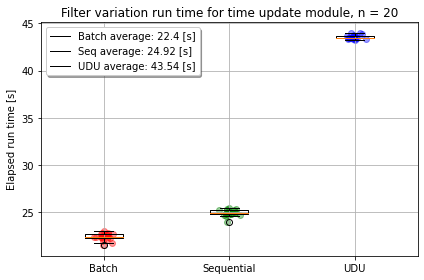

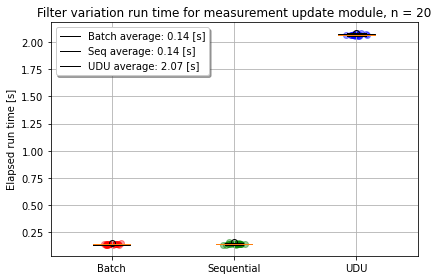

In [64]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

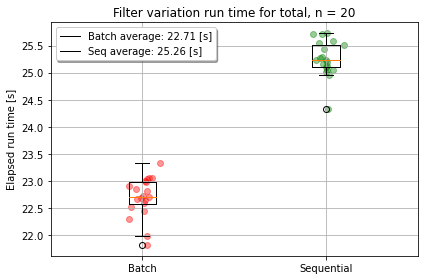

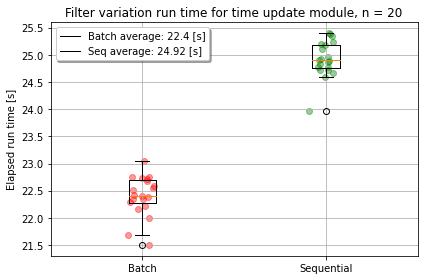

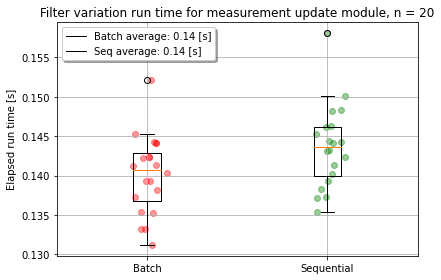

In [65]:
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    if (N ==10/dt):
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing10','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing10','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==100/dt):
        plot_timing_scatter2('timing100','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing100','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing100','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==600/dt):
        plot_timing_scatter2('timing600','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing600','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing600','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==1000/dt):
        plot_timing_scatter2('timing1000','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing1000','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing1000','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                

In [66]:
from plotter import plot_NEES, plot_NIS, plot_angle, plot_error_pos_sigma, plot_error_vel_sigma, plot_path, state_error_plots
from typing import Tuple, Sequence, Any
from matplotlib import pyplot as plt


# from plotfunctionstesting import plot_acc, plot_acc2, plot_gyro, plot_angle

import numpy as np
import scipy.linalg as la
import scipy
import scipy.io
import scipy.stats
from dataclasses import dataclass, field
import timeit
import time

import tqdm
import os
import sys

from tqdm import trange
from tqdm import tqdm_notebook

from quaternion import * 
from cat_slice import CatSlice
# from eskf import ESKF
# from eskf import ESKF

from utils import UDU_factorization

from eskf_batch import ESKF_batch
from eskf_sequential import ESKF_sequential
from eskf_UDU import ESKF_udu
from eskf_runner import run_batch_eskf, run_sequential_eskf, run_UDU_eskf
from plotter import * #plot_error_v_sigma, plot_pos, plot_vel, plot_angle, plot_estimate, plot_3Dpath, plot_path, state_error_plots, plot_NEES, plot_NIS
# from timer import * 

In [67]:
plt.close('all')

from plot_setup import setup_plot
setup_plot()
np.seterr(all='raise')
scipy.special.seterr(all='raise')

matplotlib backend: module://matplotlib_inline.backend_inline
matplotlib config file: C:\Python39\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\Users\Andreas\.matplotlib
Plotting is set to inline at the moment: unknown inline backend
continuing with this plotting backend


pyplot using style set ['science', 'grid', 'no-latex']


{'singular': 'raise',
 'underflow': 'raise',
 'overflow': 'raise',
 'slow': 'raise',
 'loss': 'raise',
 'no_result': 'raise',
 'domain': 'raise',
 'arg': 'raise',
 'other': 'raise'}

In [68]:
"""
Q_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std
R: p_std -> R_GNSS = p_std**2*eye(3)
"""

'\nQ_err: acc_std, gyro_std, acc_bias_Std, gyro_bias std\nR: p_std -> R_GNSS = p_std**2*eye(3)\n'

In [69]:
"""
Loads true state, time steps and other simulation variables. Run gen_mat to generate
new data
"""

folder = os.path.dirname(__file__)
# filename_to_load = f"{folder}/../data/simulation_params.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long.mat"
# filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver2.mat"
filename_to_load = f"{folder}/../data/simulation_params_comb_maneuver_long_ver3.mat"
cache_folder = os.path.join(folder,'..', 'cache')
loaded_data = scipy.io.loadmat(filename_to_load)

timeIMU = loaded_data["timeIMU"].ravel()
#acc_t = loaded_data["acc_t"].T
if 'x_true' in loaded_data:
    x_true = loaded_data["x_true"].T
else:
    x_true = None
# z_GNSS = loaded_data["z_GNSS"].T
    
beacon_location = loaded_data["beacon_location"]

tGNSS = loaded_data["timeGNSS"].T
z_GNSS = loaded_data["z_GNSS"].T

z_acc_vector = loaded_data["z_acc"].T
acc_t = loaded_data["acc_t"].T
omega_t = loaded_data["omega_t"].T
z_gyro_vector = loaded_data["z_gyro"].T

dt = np.mean(np.diff(timeIMU))

In [70]:
POS_IDX = CatSlice(start=0, stop=3)
VEL_IDX = CatSlice(start=3, stop=6)
ATT_IDX = CatSlice(start=6, stop=10)
ACC_BIAS_IDX = CatSlice(start=10, stop=13)
GYRO_BIAS_IDX = CatSlice(start=13, stop=16)

ERR_ATT_IDX = CatSlice(start=6, stop=9)
ERR_ACC_BIAS_IDX = CatSlice(start=9, stop=12)
ERR_GYRO_BIAS_IDX = CatSlice(start=12, stop=15)

In [71]:
# Initializing prediction
x_pred_init = np.zeros(16)

# 8 figure init
x_pred_init[POS_IDX] = np.array([10,0,1])
x_pred_init[VEL_IDX] = np.array([0, 2, 0])
x_pred_init[6:10] = np.array([1,0,0,0]) #(0,0,0) iny euler
# x_pred_init[10:13] = np.array([-8.75e-2,-8.74e-2,6.9e-2])
# x_pred_init[13:16] = np.array([-9.54e-4,-7.32e-04,3.37e-04])

# x_pred_init[POS_IDX] = np.array([0, 0, -5])  # starting 5 metres above ground
# x_pred_init[VEL_IDX] = np.array([20, 0, 0])  # starting at 20 m/s due north
# no initial rotation: nose to North, right to East, and belly down
# x_pred_init[6] = 1

In [72]:
# acc_std = 7.59562072e-02
# rate_std =  5.12679127e-02

# cont_acc_bias_driving_noise_std =  1.16562328e-04
# cont_rate_bias_driving_noise_std =  1.94631260e-05

In [73]:
# TUNABLE0.01035
# cont_gyro_noise_std =  0.01035
cont_gyro_noise_std =   4.36e-5  # (rad/s)/sqrt(Hz)
# TUNABLE 0.015191 
# cont_acc_noise_std = np.array([0.01, 0.01, 0.042191])
# cont_acc_noise_std = 0.01549 #1.167e-2  # (m/s**2)/sqrt(Hz)
cont_acc_noise_std =  1.167e-2  # (m/s**2)/sqrt(Hz)

# cont_gyro_noise_std = 0.001      #4.36e-5  # (rad/s)/sqrt(Hz)
# cont_acc_noise_std = 0.001  #1.167e-3  # (m/s**2)/sqrt(Hz)

# Discrete sample noise at simulation rate used
# This is the formula from example 4.9. Should this be the driving noise instead?
rate_std = np.round(0.5 * cont_gyro_noise_std * np.sqrt(1 / dt),7) #Just to avoid float shit
acc_std = np.round(0.5 * cont_acc_noise_std * np.sqrt(1 / dt),7)

# Bias values
# TUNABLE 0.0005839  0.00005839 
# 5e-5 From another simulation
rate_bias_driving_noise_std =  5e-5 

cont_rate_bias_driving_noise_std = (
    np.round((1 / 3) * rate_bias_driving_noise_std / np.sqrt(1 / dt), 7)
)
#4e-3 From another simulation
#0.0001947, 0.0020947 0.0050947
acc_bias_driving_noise_std = 4e-3
cont_acc_bias_driving_noise_std = 6 * acc_bias_driving_noise_std / np.sqrt(1 / dt)

In [74]:
p_acc =   1.000e-6
p_gyro = 1.00000000e-6

In [75]:
# p_std = np.array([1.58170828, 1.58170828, 0.97243219])   # Measurement noise

#The measurements from the GNSS are perfect at the moment
# p_std = np.array([0, 0, 0])
p_std = np.array([.01, .01, .03])
# p_std = np.array([.1, .1, .3])
# p_std = np.array([.3, .3, .5])

In [76]:
P_pred_init = np.zeros((15,15))
P_pred_init[POS_IDX ** 2] = np.eye(3) * 3**2  
P_pred_init[VEL_IDX ** 2] = np.eye(3) * 2**2  #0.2
P_pred_init[ERR_ATT_IDX ** 2] = np.eye(3) * 0.5**2  # TODO
P_pred_init[ERR_ACC_BIAS_IDX ** 2] = np.eye(3) * 0.01**2 
P_pred_init[ERR_GYRO_BIAS_IDX ** 2] = np.eye(3) * 0.001**2 # 0.001**2 
 
eskf_parameters = [acc_std,
                    rate_std,
                    cont_acc_bias_driving_noise_std,
                    cont_rate_bias_driving_noise_std,
                    p_acc,
                    p_gyro]   

In [77]:
#Number of seconds of simulation to run. len(timeIMU) decides max

# N: int = int(10/dt) 
# N: int = int(100/dt)
N: int = int(600/dt) 
# N: int = int(1000/dt)
# N: int = int(90000)
# N: int = len(timeIMU)
offset = 0
doGNSS: bool = True
# rtol = 1e-05
# atol = 1e-08

In [78]:
# plt.close("all")
t = np.linspace(0,dt * (N-1), N)
# plot_path(t, N, pos_t, pos_t)

In [79]:
"""
Running the simulation
"""
beacon_location: np.ndarray = loaded_data["beacon_location"]

use_batch_pseudoranges: bool = True
# use_batch_pseudoranges: bool = False
use_sequential_pseudoranges: bool = True
# use_sequential_pseudoranges: bool = False
use_UDU: bool = True
# use_UDU: bool = False

num_beacons = len(beacon_location)
num_sims = 20

#Timers for batch-filter
t_batch = np.zeros(num_sims)
elapsed_batch = np.zeros(num_sims)

#Timers for sequential filter
t_sequential = np.zeros(num_sims)
elapsed_sequential = np.zeros(num_sims)

#Timers for UDU filter
t_UDU = np.zeros(num_sims)
elapsed_UDU = np.zeros(num_sims)

#Timers for submodules
total_elapsed_pred_timer_batch = np.zeros(num_sims)
total_elapsed_est_timer_batch = np.zeros(num_sims)
average_elapsed_pred_timer_batch = np.zeros(num_sims)
average_elapsed_est_timer_batch = np.zeros(num_sims)

total_elapsed_pred_timer_sequential = np.zeros(num_sims)
total_elapsed_est_timer_sequential = np.zeros(num_sims)
average_elapsed_pred_timer_sequential = np.zeros(num_sims)
average_elapsed_est_timer_sequential = np.zeros(num_sims)

total_elapsed_pred_timer_UDU = np.zeros(num_sims)
total_elapsed_est_timer_UDU = np.zeros(num_sims)
average_elapsed_pred_timer_UDU = np.zeros(num_sims)
average_elapsed_est_timer_UDU = np.zeros(num_sims)


Number of beacons used:  15
Number of simulations ran through 20
Simulation duration (seconds):  600.0

Using batch pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:17<00:00, 437.02it/s]



Using batch pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:15<00:00, 442.76it/s]



Using batch pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:16<00:00, 440.53it/s]



Using batch pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:16<00:00, 438.94it/s]



Using batch pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:16<00:00, 439.06it/s]



Using batch pseudoranges without factorization. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:17<00:00, 435.15it/s]



Using batch pseudoranges without factorization. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:18<00:00, 434.00it/s]



Using batch pseudoranges without factorization. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:16<00:00, 438.90it/s]



Using batch pseudoranges without factorization. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:20<00:00, 427.79it/s]



Using batch pseudoranges without factorization. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 376.69it/s]



Using batch pseudoranges without factorization. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 374.79it/s]



Using batch pseudoranges without factorization. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 373.14it/s]



Using batch pseudoranges without factorization. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 375.85it/s]



Using batch pseudoranges without factorization. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:37<00:00, 381.61it/s]



Using batch pseudoranges without factorization. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:38<00:00, 377.71it/s]



Using batch pseudoranges without factorization. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:38<00:00, 377.50it/s]



Using batch pseudoranges without factorization. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 375.53it/s]



Using batch pseudoranges without factorization. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 376.25it/s]



Using batch pseudoranges without factorization. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:22<00:00, 421.15it/s]



Using batch pseudoranges without factorization. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:21<00:00, 423.34it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpare

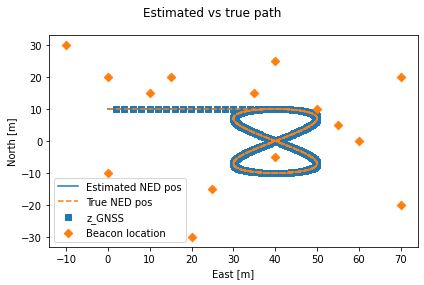

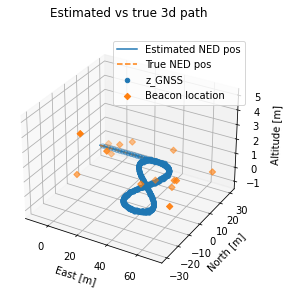

<Figure size 432x288 with 0 Axes>

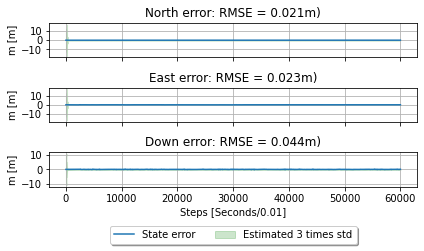

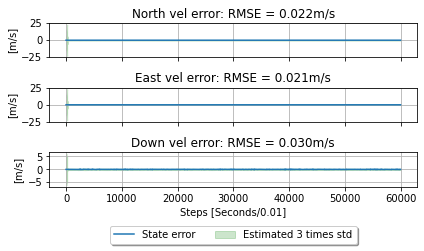

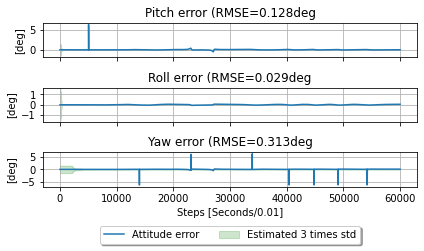

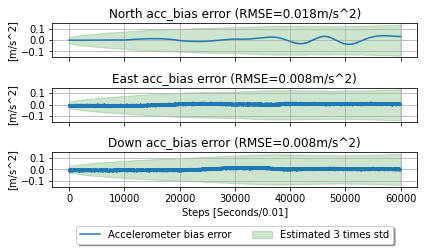

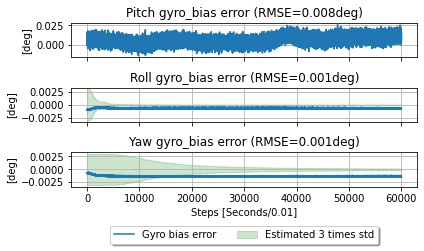

In [80]:
print("\nNumber of beacons used: ", num_beacons)
print("Number of simulations ran through", num_sims)
print("Simulation duration (seconds): ", N*dt) 

# %
if (use_batch_pseudoranges):
    for i in range(num_sims):  
        # timeit.timeit()
        print("\nUsing batch pseudoranges without factorization. Run number: ", i+1)
        
        t_batch[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        est_timer,
        pred_timer,
        elapsed_pred_timer_batch,
        elapsed_est_timer_batch
        ) = run_batch_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_batch[i] = time.time() - t_batch[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_batch[i] = np.sum(elapsed_pred_timer_batch)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_batch[i] = np.sum(elapsed_est_timer_batch)


    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path_batch',x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'batch', 'path3d_batch',x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'batch', 'error_pos_sigma_batch')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'batch', 'error_vel_sigma_batch')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'batch', 'error_att_sigma_batch')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_acc_bias_sigma_batch')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'batch', 'error_rate_bias_sigma_batch')
    # Batch timings

In [81]:
    print("\nEllapsed time for batch: ", np.round(elapsed_batch,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_batch,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_batch/elapsed_batch*100,3), "%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_batch,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_batch/elapsed_batch*100,3), "%")

    average_time_batch = np.round(np.average(elapsed_batch),3)
    print("\nAverage time for batch elapsed: ", average_time_batch, "seconds")
    average_elapsed_pred_timer_batch = np.round(np.average(total_elapsed_pred_timer_batch),3)
    average_elapsed_est_timer_batch = np.round(np.average(total_elapsed_est_timer_batch),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_batch, ", where average occupies =", np.round(average_elapsed_pred_timer_batch/average_time_batch*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_batch, ", where average occupies =", np.round(average_elapsed_est_timer_batch/average_time_batch*100,3), "% " "relative to total time")


Ellapsed time for batch:  [137.328 135.549 136.251 136.728 136.693 137.924 138.287 136.743 140.296
 159.327 160.123 160.835 159.674 157.266 158.896 158.978 159.811 159.506
 142.504 141.768]
Summed runtime used in prediction module:  [135.679 133.889 134.608 135.059 135.059 136.242 136.562 135.094 138.634
 157.844 158.665 159.403 158.249 155.849 157.412 157.494 158.394 158.037
 140.966 140.128] seconds
Portion of runtime prediction module occupies:  [98.799 98.775 98.795 98.779 98.804 98.78  98.753 98.794 98.816 99.069
 99.089 99.109 99.108 99.099 99.066 99.066 99.113 99.079 98.921 98.843] %
Summed runtime used in estimation module:  [0.846 0.812 0.829 0.838 0.831 0.841 0.844 0.817 0.825 0.782 0.785 0.783
 0.765 0.784 0.778 0.803 0.766 0.781 0.811 0.828] seconds
Portion of runtime estimation module occupies:  [0.616 0.599 0.609 0.613 0.608 0.61  0.611 0.598 0.588 0.491 0.49  0.487
 0.479 0.498 0.489 0.505 0.479 0.49  0.569 0.584] %

Average time for batch elapsed:  147.724 seconds
Aver


Using sequential pseudoranges without factorization. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:17<00:00, 437.45it/s]



Using sequential pseudoranges without factorization. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:33<00:00, 390.95it/s]



Using sequential pseudoranges without factorization. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:34<00:00, 387.52it/s]



Using sequential pseudoranges without factorization. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:33<00:00, 389.93it/s]



Using sequential pseudoranges without factorization. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:33<00:00, 390.53it/s]



Using sequential pseudoranges without factorization. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:33<00:00, 390.46it/s]



Using sequential pseudoranges without factorization. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:36<00:00, 382.58it/s]



Using sequential pseudoranges without factorization. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 376.47it/s]



Using sequential pseudoranges without factorization. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 375.56it/s]



Using sequential pseudoranges without factorization. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 374.58it/s]



Using sequential pseudoranges without factorization. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 374.13it/s]



Using sequential pseudoranges without factorization. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 376.74it/s]



Using sequential pseudoranges without factorization. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:39<00:00, 376.97it/s]



Using sequential pseudoranges without factorization. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 373.30it/s]



Using sequential pseudoranges without factorization. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 372.78it/s]



Using sequential pseudoranges without factorization. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:41<00:00, 371.97it/s]



Using sequential pseudoranges without factorization. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 374.64it/s]



Using sequential pseudoranges without factorization. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 373.85it/s]



Using sequential pseudoranges without factorization. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:41<00:00, 371.38it/s]



Using sequential pseudoranges without factorization. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [02:40<00:00, 374.80it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpare

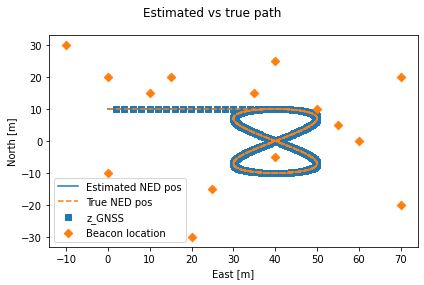

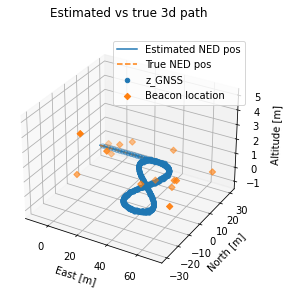

<Figure size 432x288 with 0 Axes>

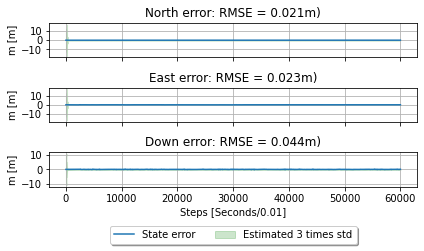

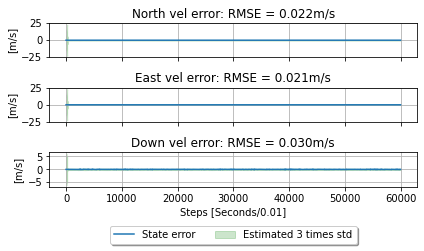

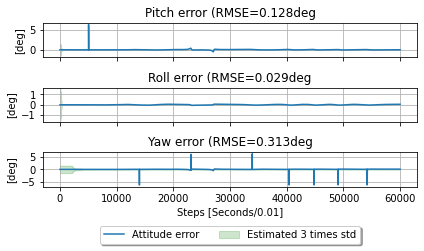

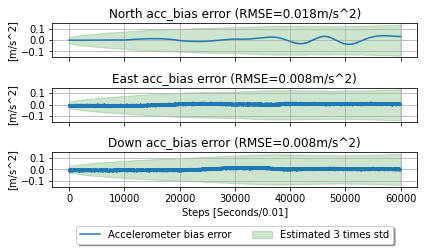

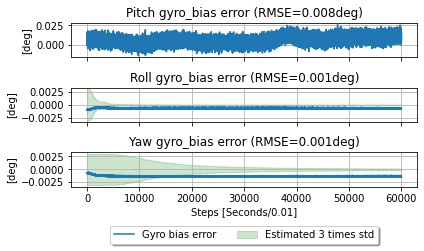

In [82]:
if (use_sequential_pseudoranges):
    for i in range(num_sims):
        print("\nUsing sequential pseudoranges without factorization. Run number: ", i+1)  
        # timeit.timeit()
        t_sequential[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_sequential,
        elapsed_est_timer_sequential
        ) = run_sequential_eskf (
                            N, loaded_data,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
            
        elapsed_sequential[i] = time.time() - t_sequential[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_sequential[i] = np.sum(elapsed_pred_timer_sequential)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_sequential[i] = np.sum(elapsed_est_timer_sequential)

    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path_seq', x_true)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'sequential', 'path3d_seq', x_true)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'sequential', 'error_pos_sigma_seq')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'sequential', 'error_vel_sigma_seq')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'sequential', 'error_att_sigma_seq')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_acc_bias_sigma_seq')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'sequential', 'error_rate_bias_sigma_seq')
    
    ## Sequential timings

In [83]:
    print("\nEllapsed time for sequential: ", np.round(elapsed_sequential,3))
    print("Summed runtime used in prediction module: ", np.round(total_elapsed_pred_timer_sequential,3), "seconds")
    print("Portion of runtime prediction module occupies: ", np.round(total_elapsed_pred_timer_sequential/elapsed_sequential*100,3),"%")
    print("Summed runtime used in estimation module: ", np.round(total_elapsed_est_timer_sequential,3), "seconds")
    print("Portion of runtime estimation module occupies: ", np.round(total_elapsed_est_timer_sequential/elapsed_sequential*100,3),"%")
  

    average_time_sequential = np.round(np.average(elapsed_sequential),3)
    print("\nAverage time for sequential elapsed: ", average_time_sequential, "seconds")
    average_elapsed_pred_timer_sequential = np.round(np.average(total_elapsed_pred_timer_sequential),3)
    average_elapsed_est_timer_sequential = np.round(np.average(total_elapsed_est_timer_sequential),3)
    print("Average runtime for prediction module: ", average_elapsed_pred_timer_sequential, ", where average occupies =", np.round(average_elapsed_pred_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")
    print("Average runtime for estimation module: ", average_elapsed_est_timer_sequential, ", where average occupies =", np.round(average_elapsed_est_timer_sequential/average_time_sequential*100,3), "% " "relative to total time")


Ellapsed time for sequential:  [137.202 153.514 154.872 153.917 153.678 153.705 156.87  159.418 159.798
 160.217 160.407 159.296 159.218 160.764 160.985 161.339 160.19  160.532
 161.602 160.124]
Summed runtime used in prediction module:  [135.347 151.598 152.993 152.002 151.762 151.832 155.181 157.949 158.328
 158.758 159.001 157.868 157.713 159.269 159.53  159.929 158.763 159.073
 160.216 158.633] seconds
Portion of runtime prediction module occupies:  [98.648 98.752 98.787 98.755 98.753 98.782 98.924 99.079 99.08  99.089
 99.123 99.104 99.055 99.07  99.096 99.126 99.109 99.091 99.142 99.069] %
Summed runtime used in estimation module:  [0.849 0.882 0.875 0.883 0.884 0.864 0.799 0.757 0.751 0.76  0.741 0.779
 0.784 0.769 0.772 0.745 0.768 0.752 0.738 0.765] seconds
Portion of runtime estimation module occupies:  [0.619 0.575 0.565 0.573 0.575 0.562 0.509 0.475 0.47  0.474 0.462 0.489
 0.492 0.478 0.48  0.462 0.479 0.468 0.457 0.478] %

Average time for sequential elapsed:  157.382 se

Using sequential pseudoranges with UDU Propagation. Run number:  1
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:04<00:00, 197.14it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  2
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:12<00:00, 192.25it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  3
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:13<00:00, 191.27it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  4
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:50<00:00, 206.86it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  5
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:36<00:00, 217.17it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  6
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:37<00:00, 216.44it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  7
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:37<00:00, 215.90it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  8
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:40<00:00, 213.84it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  9
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:14<00:00, 190.89it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  10
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:15<00:00, 190.15it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  11
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:12<00:00, 192.12it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  12
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:14<00:00, 190.81it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  13
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:52<00:00, 205.13it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  14
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:40<00:00, 214.04it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  15
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:43<00:00, 211.63it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  16
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:43<00:00, 211.61it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  17
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:44<00:00, 211.26it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  18
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:10<00:00, 193.24it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  19
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [05:09<00:00, 193.59it/s]


Using sequential pseudoranges with UDU Propagation. Run number:  20
Not using GNSS_accuracy
Initializing kalman filter
Running filter on simulation model


100%|██████████| 60000/60000 [04:42<00:00, 212.31it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpare

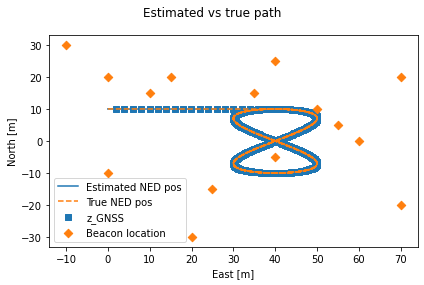

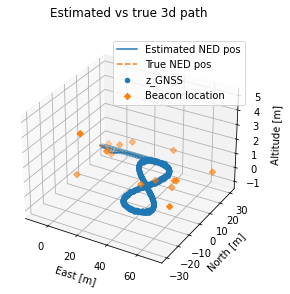

<Figure size 432x288 with 0 Axes>

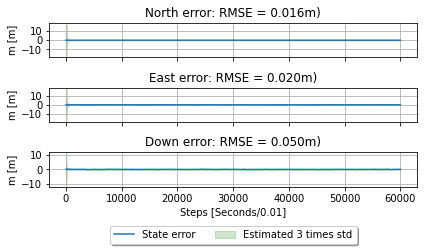

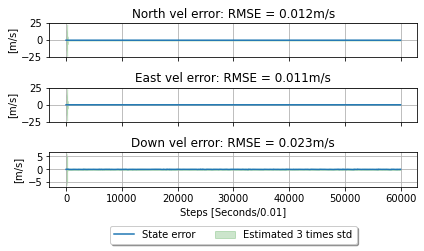

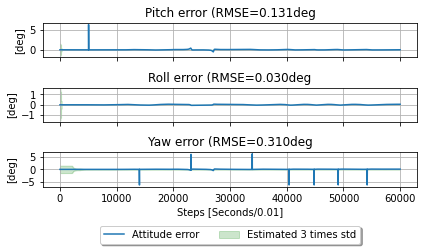

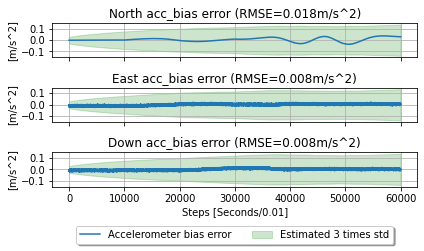

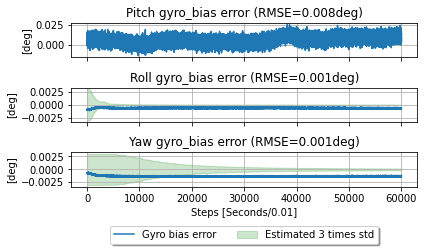

In [84]:
if (use_UDU):
    for i in range(num_sims):  
        # timeit.timeit()
        print("Using sequential pseudoranges with UDU Propagation. Run number: ", i+1)
        
        t_UDU[i] = time.time()
        
        (x_pred,
        x_est,
        P_est,
        GNSSk,
        elapsed_pred_timer_UDU,
        elapsed_est_timer_UDU
        ) = run_UDU_eskf (
                            N, loaded_data,
                            use_UDU,
                            eskf_parameters,
                            x_pred_init, P_pred_init, p_std, 
                            num_beacons,
                            offset =0.0, 
                            use_GNSSaccuracy=False, doGNSS=True,
                            debug=False
                            )
        elapsed_UDU[i] = time.time() - t_UDU[i]
        #Summed up time used in prediction steps
        total_elapsed_pred_timer_UDU[i] = np.sum(elapsed_pred_timer_UDU)
        #Summed up time used in estimation steps
        total_elapsed_est_timer_UDU[i] = np.sum(elapsed_est_timer_UDU)
        
    #Plot the latest run and save figures
    plot_path(t,N, beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path_udu', x_true,)
    plot_3Dpath(t, N,beacon_location[:num_beacons], GNSSk, z_GNSS, x_est, 'udu', 'path3d_udu', x_true,)
    plot_error_pos_sigma(x_est, x_true, P_est, N, 'udu', 'error_pos_sigma_udu')
    plot_error_vel_sigma(x_est, x_true, P_est, N, 'udu', 'error_vel_sigma_udu')
    plot_error_att_sigma(x_est, x_true, P_est, N, 'udu', 'error_att_sigma_udu')
    plot_error_acc_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_acc_bias_sigma_udu')  
    plot_error_rate_bias_sigma(x_est, x_true, P_est, N, 'udu', 'error_rate_bias_sigma_udu')
    ## UDU timings

In [85]:
    print("\nEllapsed time for UDU: ",  np.round(elapsed_UDU,3))
    print("Summed runtime used in UDU prediction module: ",  np.round(total_elapsed_pred_timer_UDU,3), "seconds")
    print("Portion of runtime prediction module in UDU occupies: ",  np.round(total_elapsed_pred_timer_UDU/elapsed_UDU,3),"%")
    print("Summed runtime used in UDU estimation module: ",  np.round(total_elapsed_est_timer_UDU,3), "seconds")
    print("Portion of runtime estimation module in UDU ccupies: ",  np.round(total_elapsed_est_timer_UDU/elapsed_UDU,3),"%")

    average_time_UDU = np.round(np.average(elapsed_UDU),3)
    print("\nAverage time for UDU elapsed: ", np.round(average_time_UDU,3), "seconds")
    average_elapsed_pred_timer_UDU = np.round(np.average(total_elapsed_pred_timer_UDU),3)
    average_elapsed_est_timer_UDU = np.round(np.average(total_elapsed_est_timer_UDU),3)
    print("Average runtime for prediction module in UDU: ", average_elapsed_pred_timer_UDU, ", where average occupies =",  np.round(average_elapsed_pred_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")
    print("Average runtime for estimation module in UDU: ", average_elapsed_est_timer_UDU, ", where average occupies =",  np.round(average_elapsed_est_timer_UDU/average_time_UDU*100,3), "% " "relative to total time")


Ellapsed time for UDU:  [304.388 312.126 313.74  290.088 276.313 277.254 277.951 280.622 314.362
 315.571 312.339 314.489 292.537 280.352 283.547 283.576 284.045 310.543
 309.967 282.647]
Summed runtime used in UDU prediction module:  [290.769 298.57  300.123 276.121 262.057 263.047 263.68  266.488 300.723
 301.967 298.832 300.89  278.765 266.334 269.569 269.536 270.069 296.956
 296.32  268.632] seconds
Portion of runtime prediction module in UDU occupies:  [0.955 0.957 0.957 0.952 0.948 0.949 0.949 0.95  0.957 0.957 0.957 0.957
 0.953 0.95  0.951 0.95  0.951 0.956 0.956 0.95 ] %
Summed runtime used in UDU estimation module:  [11.85  11.859 11.852 12.182 12.426 12.382 12.398 12.318 11.826 11.856
 11.811 11.834 12.03  12.21  12.228 12.212 12.153 11.857 11.896 12.221] seconds
Portion of runtime estimation module in UDU ccupies:  [0.039 0.038 0.038 0.042 0.045 0.045 0.045 0.044 0.038 0.038 0.038 0.038
 0.041 0.044 0.043 0.043 0.043 0.038 0.038 0.043] %

Average time for UDU elapsed:  295

In [86]:
## Relative relations
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of batch vs sequential: ",  np.round((average_time_batch - average_time_sequential)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_sequential)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_sequential)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs sequential:  -6.538 %
Average Relative speedup of pred module in batch vs sequential:  -6.584 %
Average Relative speedup of est module in batch vs sequential:  1.363 %


In [87]:
if (use_batch_pseudoranges & use_UDU):
    print("\nAverage Relative speedup of batch vs UDU-sequential: ",  np.round((average_time_batch - average_time_UDU)/average_time_batch*100,3),"%")
    print("Average Relative speedup of pred module in batch vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_batch - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_batch*100,3), "%")
    print("Average Relative speedup of est module in batch vs UDU-sequential: ",  np.round((average_elapsed_est_timer_batch - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_batch*100,3), "%")


Average Relative speedup of batch vs UDU-sequential:  -100.254 %
Average Relative speedup of pred module in batch vs UDU-sequential:  -92.916 %
Average Relative speedup of est module in batch vs UDU-sequential:  -1395.663 %


In [88]:
if (use_UDU & use_sequential_pseudoranges):
    print("\nAverage Relative speedup of sequential vs UDU-sequential: ",  np.round((average_time_sequential - average_time_UDU)/average_time_sequential*100,3),"%")
    print("Average Relative speedup of pred module in sequential vs UDU-sequential: ",  np.round((average_elapsed_pred_timer_sequential - average_elapsed_pred_timer_UDU)/average_elapsed_pred_timer_sequential*100,3), "%")
    print("Average Relative speedup of est module in  sequential vs UDU-sequential: ",  np.round((average_elapsed_est_timer_sequential - average_elapsed_est_timer_UDU)/average_elapsed_est_timer_sequential*100,3), "%")


Average Relative speedup of sequential vs UDU-sequential:  -87.965 %
Average Relative speedup of pred module in sequential vs UDU-sequential:  -80.998 %
Average Relative speedup of est module in  sequential vs UDU-sequential:  -1416.332 %


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

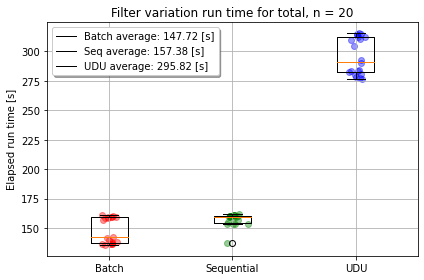

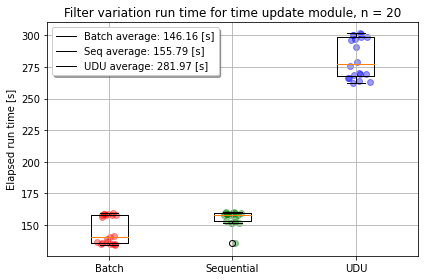

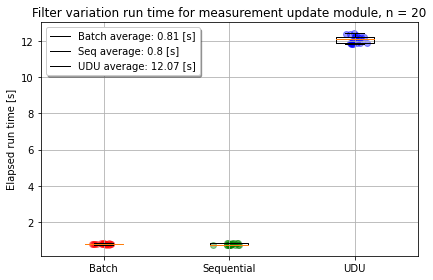

In [89]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing100','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing100','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing100','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

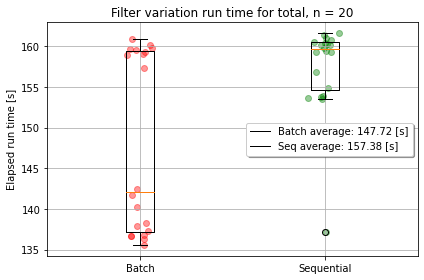

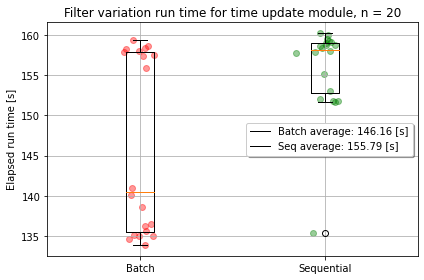

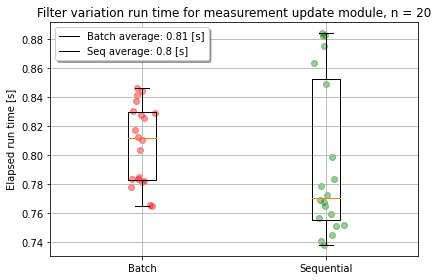

In [90]:
if (use_batch_pseudoranges & use_sequential_pseudoranges):
    if (N ==10/dt):
        plot_timing_scatter2('timing10','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing10','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing10','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==100/dt):
        plot_timing_scatter2('timing100','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing100','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing100','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==600/dt):
        plot_timing_scatter2('timing600','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing600','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing600','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                
    if (N ==1000/dt):
        plot_timing_scatter2('timing1000','2Total_elapsed_box','total',elapsed_batch,elapsed_sequential)
        plot_timing_scatter2('timing1000','2Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential)
        plot_timing_scatter2('timing1000','2Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential)                

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

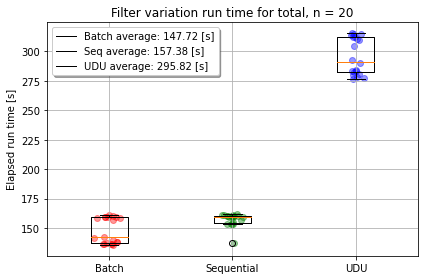

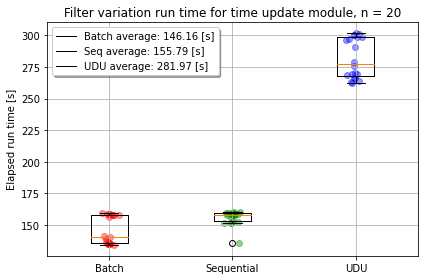

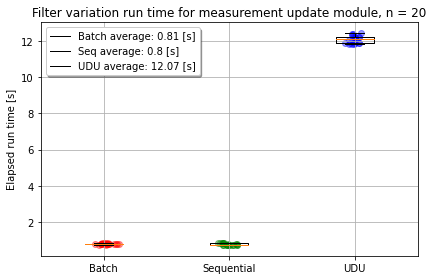

In [91]:
if (use_batch_pseudoranges & use_sequential_pseudoranges & use_UDU):
    if (N ==10/dt):
        plot_timing_scatter('timing10','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing10','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing10','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)
        
    if (N ==100/dt):
        plot_timing_scatter('timing100','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing100','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing100','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==600/dt):
        plot_timing_scatter('timing600','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing600','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing600','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                
        
    if (N ==1000/dt):
        plot_timing_scatter('timing1000','1Total_elapsed_box','total',elapsed_batch,elapsed_sequential,elapsed_UDU)
        plot_timing_scatter('timing1000','1Pred_elapsed_box','time update module',total_elapsed_pred_timer_batch,total_elapsed_pred_timer_sequential,total_elapsed_pred_timer_UDU)
        plot_timing_scatter('timing1000','1Est_elapsed_box','measurement update module',total_elapsed_est_timer_batch,total_elapsed_est_timer_sequential,total_elapsed_est_timer_UDU)                                